# Thank you everyone!
This notebook is 62nd solution of this competition.
I used single light GBM and got following score.
* CV score 0.801
* Public LB score 0.799
* Private LB score 0.801

Blending with catboost and SAKT did not work well for me.

Throughout this competition, I learned a lot from many notebook and comments of other kagglers.
I appreciate all these people and want to add them in this notebook. Correct me if I missed someone.

Due to the luck of my programming skill, the code is very dirty. 
Any questions are wellcome.

# The list of abbreviations in feature names
- acc: answered_correctly
- exp: prior_question_had_explanation
- time: prior_question_elapsed_time
- count: number of trial
- count_lecture: number of lecture
- tfl: timestamp from last nth trial to that from n+1th trial
- dif: difficulty (1 - content-wise accuracy)
- dpt: difficulty point (add difficulty if users answer was correct)
- avg: average
- std: standard deviation
- sum: sum
- hist: historical average with temporal decay of gamma 0.75 
- hist2: historical average with temporal decay of gamma 0.25
- u: user-wise
- t: tag-wise
- tg: taggroup-wise
- p: part-wise
- c: content-wise
- b: bundle-wise
- uc: user-content-wise
- ub: user-bundle-wise
- up: user-part-wise
- time_per_count_u: timestamp/count_u
- count_u_nondiagnostic: user-wise count of non-diagnostic questions
- exp_avg_u_corrected: user-wise average of prior_question_had_explanation corrected for diagnostic questions. Th user cannot read explanation for diagnostic questions.
- pp_ratio: ratio of paid part (part1, 3, 4, 6, 7) trials per all trials, only paid users of SANTA app can solve them if it is not diagnostic questions
- listening_ratio: ratio of listening part trials per all trials
- relative_dif: relative difficulty of questions calculated with acc_avg_c / dif_avg_u
- notacc_sum: sum of failed trials
- wp_ts: trueskill feature of win probability
- umu_ts, usigma_ts, qmu_ts, qsigma_ts: trueskill features of mu, and sigma of user and content

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import gc
from collections import defaultdict
from tqdm.notebook import tqdm
import lightgbm as lgb
import time
import pickle
import seaborn as sns
import dill
import re
import sqlite3
from pathlib import Path
from contextlib import contextmanager
from trueskill import Rating, quality_1vs1, rate_1vs1
import trueskill
import math
from sklearn.preprocessing import LabelEncoder
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

def pickle_dump_dill(obj, path):
    with open(path, mode='wb') as f:
        dill.dump(obj,f)

def pickle_load_dill(path):
    with open(path, mode='rb') as f:
        data = dill.load(f)
        return data  

def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj,f)

def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# Import data
CV files are from [this great notebook](https://www.kaggle.com/its7171/cv-strategy) by @tito

In [3]:
train_pickle = '../input/riiid-cross-validation-files/cv1_train.pickle'
valid_pickle = '../input/riiid-cross-validation-files/cv1_valid.pickle'

feld_needed = ['timestamp','user_id', 'content_id', 'content_type_id', 'answered_correctly', 'prior_question_elapsed_time', 'prior_question_had_explanation']

#%%
train = pd.read_pickle(train_pickle)[feld_needed]
valid = pd.read_pickle(valid_pickle)[feld_needed]

I trained my model on my local PC. In the Kaggle notebook, I reduced datasize for presentation.

In [4]:
kaggle=True
if kaggle:
    train=train[:10000]
    valid=valid[:10000]

In [5]:
train.timestamp=(train.timestamp/1000).astype('int32')
valid.timestamp=(valid.timestamp/1000).astype('int32')

train = reduce_mem_usage(train, use_float16=False)
valid = reduce_mem_usage(valid, use_float16=False)

Memory usage of dataframe is 0.17 MB
Memory usage after optimization is: 0.19 MB
Decreased by -11.1%
Memory usage of dataframe is 0.17 MB
Memory usage after optimization is: 0.19 MB
Decreased by -11.1%


# Add prior content_id, bundle_id, part, and taggroups
prior_question_had_explanation and prior_question_elapsed_time are associated with prior bundles, not current ones. So, I add these features at first.

In [6]:
def add_prior_b(df, questions_cb, questions_bpt, prior_b_dict, verbose=True):
    df = df.merge(questions_cb, how = 'left', on = 'content_id')
    df['bundle_id'] = (df['bundle_id'].fillna(99999)).astype('int32')
    prior_b = np.zeros(len(df), dtype=np.int32)
    for cnt,row in (enumerate(tqdm(df[['user_id','content_type_id','bundle_id']].values)) if verbose else enumerate(df[['user_id','content_type_id','bundle_id']].values)):
        user_id=int(row[0])
        content_type_id=int(row[1])
        bundle_id=int(row[2])
        if prior_b_dict[user_id][0] != bundle_id:
            prior_b[cnt] = prior_b_dict[user_id][0]
            if (content_type_id == 0):
                prior_b_dict[user_id][1] = prior_b_dict[user_id][0]
                prior_b_dict[user_id][0] = bundle_id
        else:
            prior_b[cnt] = prior_b_dict[user_id][1]
    df['prior_bundle']=prior_b
    df = df.merge(questions_bpt, how = 'left', on = 'prior_bundle')
    df['prior_bundle'] = df['prior_bundle'].fillna(99999)
    df['prior_part'] = (df['prior_part'].fillna(9)).astype('int8')
    df['prior_taggroup'] = (df['prior_taggroup'].fillna(99)).astype('int16')
    return df

In [7]:
questions = pd.read_csv('../input/riid-preprocessed/questions_with_taggroup.csv')
questions_cb=questions[['question_id', 'bundle_id']].copy()
questions_cb = reduce_mem_usage(questions_cb, use_float16=False)
questions_cb.columns=['content_id', 'bundle_id']
questions_bpt=questions[['bundle_id', 'part', 'taggroup']].copy()
questions_bpt = reduce_mem_usage(questions_bpt, use_float16=False)
questions_bpt.columns=['prior_bundle', 'prior_part', 'prior_taggroup']
questions_bpt.drop_duplicates(subset='prior_bundle', keep='first', inplace=True)
prior_b_dict = defaultdict(lambda:defaultdict(lambda:99999))
train = add_prior_b(train, questions_cb, questions_bpt, prior_b_dict)
valid = add_prior_b(valid, questions_cb, questions_bpt, prior_b_dict)

Memory usage of dataframe is 0.21 MB
Memory usage after optimization is: 0.05 MB
Decreased by 75.0%
Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.05 MB
Decreased by 83.3%


# Create dataframe to add content-wise, part-wise, tag-wise, and taggroup-wise features.
I created dataframe to add content-wise, part-wise, tag-wise, and taggroup-wise features. Taggroup is from [this notebook](https://www.kaggle.com/radema/riiid-just-another-eda-tag-clustering-wip) by radema. I modified his notebook to increase group number (to 23) and add tag 188 to content_id 10033.

In [8]:
create_content_df=False

if create_content_df:
    content_df = train[train.content_type_id==0].groupby('content_id').\
                    agg({'answered_correctly': ['mean','sum', 'count', 'std']}).reset_index()
    content_df.columns = ['content_id','acc_avg_c','acc_sum_c', 'count_c', 'acc_std_c']

    bundle_df = train[train.content_type_id==0].groupby('prior_bundle').\
                    agg({'prior_question_had_explanation': ['mean','sum', 'count', 'std'],
                         'prior_question_elapsed_time': ['mean','sum', 'count', 'std']}).reset_index()
    bundle_df.columns = ['bundle_id','exp_avg_b', 'exp_sum_b', 'exp_count_b','exp_std_b','time_avg_b',  'time_sum_b', 'time_count_b','time_std_b']

    questions.columns=['content_id', 'bundle_id', 'correct_answer', 'part', 'tags', 'taggroup']

    content_df=content_df.merge(questions, how = 'left', on = 'content_id')
    content_df=content_df.merge(bundle_df, how = 'left', on = 'bundle_id')

    # sns.pairplot(content_df[['acc_avg_c','exp_avg_b','time_avg_b']])
    # content_df[['acc_avg_c','exp_avg_b','time_avg_b']].corr()

    #content_df.loc[content_df["tags"].isnull(),"tags"]='188'
    content_df.loc[10033,'tags']='188'
    inv_rows = content_df[content_df['tags'].apply(type) == float].index
    content_df.at[inv_rows, 'tags'] = ''
    # split tag string into list of ints
    content_df['tags'] = content_df['tags'].apply(lambda x: np.array(x.split()).astype(int))

    tag_df=pd.DataFrame()
    tag_df['tags']=range(189)
    tag_columns=['acc_sum_c', 'count_c', 'exp_sum_b', 'exp_count_b','time_sum_b', 'time_count_b']
    tag_df[tag_columns]=0
    for i in range(len(content_df)):
        tags=content_df.loc[i,'tags']
        tag_df.loc[tags,tag_columns]=tag_df.loc[tags,tag_columns]+content_df.loc[i,tag_columns]
    tag_df=tag_df.astype(int)
    tag_df['acc_avg_t']=tag_df['acc_sum_c']/tag_df['count_c']
    tag_df['exp_avg_t']=tag_df['exp_sum_b']/tag_df['exp_count_b']
    tag_df['time_avg_t']=tag_df['time_sum_b']/tag_df['time_count_b']

    #content_df[['acc_avg_t2', 'exp_avg_t2', 'time_avg_t2']]=0
    for i in range(len(content_df)):
        tags=content_df.loc[i,'tags']
        content_df.loc[i,'acc_avg_t']=tag_df.loc[tags].mean()['acc_avg_t']
        content_df.loc[i,'exp_avg_t']=tag_df.loc[tags].mean()['exp_avg_t']
        content_df.loc[i,'time_avg_t']=tag_df.loc[tags].mean()['time_avg_t']
        #content_df.loc[i,'acc_avg_t2']=tag_df.loc[tags].sum()['acc_sum_c']/tag_df.loc[tags].sum()['count_c']
        #content_df.loc[i,'exp_avg_t2']=tag_df.loc[tags].sum()['exp_sum_b']/tag_df.loc[tags].sum()['exp_count_b']
        #content_df.loc[i,'time_avg_t2']=tag_df.loc[tags].sum()['time_sum_b']/tag_df.loc[tags].sum()['time_count_b']

    content_df['type_of']=4
    content_df['col_for_merge']=(content_df['content_id'].astype('int32')*10).astype('int32')

    lectures = pd.read_csv('/media/hama/ssd2/inubushi/kaggle/riid/riiid-test-answer-prediction/lectures.csv')

    le = LabelEncoder()
    le.fit(lectures['type_of'])
    lectures['type_of'] = le.transform(lectures['type_of'])
    lectures['col_for_merge']=(lectures['lecture_id']*10+1).astype('int32')

    content_df=lectures.append(content_df)

    # --- part-wise parameter
    train = train.merge(questions[['content_id', 'part']], how = 'left', on = 'content_id')
    part_df = train[train.content_type_id==0].groupby('part').\
                        agg({'answered_correctly': ['mean','sum', 'count', 'std']}).reset_index()
    part_df.columns = ['part','acc_avg_p','acc_sum_p','count_p','acc_std_p']
    part_df2 = train[train.content_type_id==0].groupby('prior_part').\
                        agg({'prior_question_had_explanation': ['mean','sum', 'count', 'std'],
                             'prior_question_elapsed_time': ['mean','sum', 'count', 'std']}).reset_index()
    part_df2.columns = ['part', 'exp_avg_p','exp_sum_p','exp_count_p','exp_std_p', 'time_avg_p','time_sum_p','time_count_p','time_std_p']
    part_df=part_df.merge(part_df2, how = 'left', on = 'part')
    train=train.drop('part', axis=1)
    content_df = content_df.merge(part_df, how = 'left', on = 'part')

    # --- taggroup-wise parameter
    train = train.merge(questions[['content_id', 'taggroup']], how = 'left', on = 'content_id')
    taggroup_df = train[train.content_type_id==0].groupby('taggroup').\
                        agg({'answered_correctly': ['mean','sum', 'count', 'std']}).reset_index()
    taggroup_df.columns = ['taggroup','acc_avg_tg','acc_sum_tg','count_tg','acc_std_tg']
    taggroup_df2 = train[train.content_type_id==0].groupby('prior_taggroup').\
                        agg({'prior_question_had_explanation': ['mean','sum', 'count', 'std'],
                             'prior_question_elapsed_time': ['mean','sum', 'count', 'std']}).reset_index()
    taggroup_df2.columns = ['taggroup', 'exp_avg_tg','exp_sum_tg','exp_count_tg','exp_std_tg', 'time_avg_tg','time_sum_tg','time_count_tg','time_std_tg']
    taggroup_df=taggroup_df.merge(taggroup_df2, how = 'left', on = 'taggroup')
    train=train.drop('taggroup', axis=1)
    content_df = content_df.merge(taggroup_df, how = 'left', on = 'taggroup')

    content_df = content_df.fillna(0)

    content_df.to_csv('content_df.csv', index=False)
else:
    content_df = pd.read_csv('../input/riid-preprocessed/content_df_all.csv')

In [9]:
content_df=content_df[['col_for_merge', 'part', 'taggroup', 'acc_avg_t', 'exp_avg_t', 'time_avg_t',
                       'acc_avg_p','acc_sum_p','count_p','acc_std_p',
                       'exp_avg_p','exp_sum_p','exp_std_p', 
                       'time_avg_p','time_sum_p','time_std_p',
                       'acc_avg_c','acc_sum_c', 'count_c','acc_std_c',
                       'exp_avg_b', 'exp_sum_b', 'exp_std_b',
                       'time_avg_b','time_sum_b','time_std_b',
                       'acc_avg_tg','acc_sum_tg','count_tg','acc_std_tg',
                       'exp_avg_tg','exp_sum_tg','exp_std_tg', 
                       'time_avg_tg','time_sum_tg','time_std_tg']]

train['col_for_merge']=(train['content_id'].astype('int32')*10+train['content_type_id']).astype('int32')
valid['col_for_merge']=(valid['content_id'].astype('int32')*10+valid['content_type_id']).astype('int32')
train = train.merge(content_df, how = 'left', on = 'col_for_merge')
valid = valid.merge(content_df, how = 'left', on = 'col_for_merge')

In [10]:
train['prior_question_elapsed_time'] = train['prior_question_elapsed_time'].fillna(25439.41)
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].fillna(False).astype('int8')
valid['prior_question_elapsed_time'] = valid['prior_question_elapsed_time'].fillna(25439.41)
valid['prior_question_had_explanation'] = valid['prior_question_had_explanation'].fillna(False).astype('int8')

train = reduce_mem_usage(train, use_float16=False)
valid = reduce_mem_usage(valid, use_float16=False)

Memory usage of dataframe is 3.05 MB
Memory usage after optimization is: 1.68 MB
Decreased by 45.0%
Memory usage of dataframe is 3.05 MB
Memory usage after optimization is: 1.68 MB
Decreased by 45.0%


# Add user-wise, user-content-wise, user-bundle-wise, and user-part-wise features with loop feature engineering
The code for adding these features are from [another great notebook](https://www.kaggle.com/its7171/lgbm-with-loop-feature-engineering) of @its7171.

In [11]:
GAMMA=0.75    
GAMMA2=0.25  
def update_std(new_value, old_std, old_sum, old_count):
    if old_count > 0:
        old_avg = old_sum/old_count
    else:
        old_avg = 0
    new_avg = (old_sum+new_value)/(old_count+1)
    new_std = ((old_count*(old_std**2+old_avg**2)+new_value**2)/(old_count+1)-new_avg**2)**(1/2)
    return new_std

def add_feats(df, acc_sum_u_dict, acc_std_u_dict, acc_hist_u_dict, acc_hist2_u_dict, 
                    exp_sum_u_dict, exp_std_u_dict, exp_hist_u_dict, exp_hist2_u_dict, 
                    time_sum_u_dict, time_std_u_dict, time_hist_u_dict, time_hist2_u_dict, 
                    dpt_sum_u_dict, dpt_std_u_dict, dpt_hist_u_dict, dpt_hist2_u_dict,
                    dif_sum_u_dict, dif_std_u_dict, dif_hist_u_dict, dif_hist2_u_dict,
                    count_u_dict, count_lecture_u_dict, 
                    last_time_u_dict, last_time2_u_dict, last_time3_u_dict,
                    last_time4_u_dict, last_time5_u_dict, last_time6_u_dict,
                    tfl_std_u_dict, tfl_hist_u_dict, tfl_hist2_u_dict, 
                    acc_sum_c_dict, exp_sum_b_dict, time_sum_b_dict,
                    acc_std_c_dict, exp_std_b_dict, time_std_b_dict,
                    count_c_dict, count_b_dict,
                    acc_sum_up_dict, acc_hist_up_dict, acc_hist2_up_dict, 
                    count_up_dict, count_lecture_up_dict, last_time_up_dict, last_time2_up_dict,
                    tfl_hist_up_dict,tfl_hist2_up_dict,
                    exp_sum_up_dict, exp_hist_up_dict, exp_hist2_up_dict, 
                    time_sum_up_dict, time_hist_up_dict, time_hist2_up_dict, 
                    count_upp_dict, 
                    acc_sum_uc_dict, acc_hist_uc_dict, acc_hist2_uc_dict,  
                    count_uc_dict, count_lecture_uc_dict, last_time_uc_dict, last_time2_uc_dict,
                    tfl_hist_uc_dict, tfl_hist2_uc_dict,
                    exp_sum_ub_dict, exp_hist_ub_dict, exp_hist2_ub_dict,
                    time_sum_ub_dict, time_hist_ub_dict, time_hist2_ub_dict, 
                    count_ub_dict):           
     acsu = np.zeros(len(df), dtype=np.int16)
     acstdu = np.zeros(len(df), dtype=np.float32)   
     achu = np.zeros(len(df), dtype=np.float32)
     achu2 = np.zeros(len(df), dtype=np.float32)     
     exsu = np.zeros(len(df), dtype=np.int16)
     exstdu = np.zeros(len(df), dtype=np.float32)  
     exhu = np.zeros(len(df), dtype=np.float32)
     exhu2 = np.zeros(len(df), dtype=np.float32)
     tisu = np.zeros(len(df), dtype=np.int32)
     tistdu = np.zeros(len(df), dtype=np.float32)  
     tihu = np.zeros(len(df), dtype=np.float32)
     tihu2 = np.zeros(len(df), dtype=np.float32)
     dpsu = np.zeros(len(df), dtype=np.float32)
     dpstdu = np.zeros(len(df), dtype=np.float32)
     dphu = np.zeros(len(df), dtype=np.float32)
     dphu2 = np.zeros(len(df), dtype=np.float32)    
     disu = np.zeros(len(df), dtype=np.float32)
     distdu = np.zeros(len(df), dtype=np.float32)  
     dihu = np.zeros(len(df), dtype=np.float32)
     dihu2 = np.zeros(len(df), dtype=np.float32)  
     cu = np.zeros(len(df), dtype=np.int16)
     clu = np.zeros(len(df), dtype=np.int16)
     tflu = np.zeros(len(df), dtype=np.int32)
     tflu2 = np.zeros(len(df), dtype=np.int32)
     tflu3 = np.zeros(len(df), dtype=np.int32)
     tflu4 = np.zeros(len(df), dtype=np.int32)
     tflu5 = np.zeros(len(df), dtype=np.int32)
     tflstdu = np.zeros(len(df), dtype=np.float32)  
     tflhu = np.zeros(len(df), dtype=np.int32)
     tflhu2 = np.zeros(len(df), dtype=np.int32)
     
     acsc = np.zeros(len(df), dtype=np.int32)
     acstdc = np.zeros(len(df), dtype=np.float32)
     exsb = np.zeros(len(df), dtype=np.int32)
     exstdb = np.zeros(len(df), dtype=np.float32)
     tisb = np.zeros(len(df), dtype=np.int32)
     tistdb = np.zeros(len(df), dtype=np.float32)
     cc = np.zeros(len(df), dtype=np.int32)
     cb = np.zeros(len(df), dtype=np.int32)   
     
     acsup = np.zeros(len(df), dtype=np.int16)
     achup = np.zeros(len(df), dtype=np.float32)
     achup2 = np.zeros(len(df), dtype=np.float32)
     cup = np.zeros(len(df), dtype=np.int16)
     clup = np.zeros(len(df), dtype=np.int16)
     tflup = np.zeros(len(df), dtype=np.int32)    
     tflhup = np.zeros(len(df), dtype=np.int32)    
     tflhup2 = np.zeros(len(df), dtype=np.int32)     
     exsup = np.zeros(len(df), dtype=np.int16)
     exhup = np.zeros(len(df), dtype=np.float32)
     exhup2 = np.zeros(len(df), dtype=np.float32)
     tisup = np.zeros(len(df), dtype=np.int32)
     tihup = np.zeros(len(df), dtype=np.float32)
     tihup2 = np.zeros(len(df), dtype=np.float32)
     cupp = np.zeros(len(df), dtype=np.int32)
     
     cup1 = np.zeros(len(df), dtype=np.int16)
     cup2 = np.zeros(len(df), dtype=np.int16)
     cup3 = np.zeros(len(df), dtype=np.int16)
     cup4 = np.zeros(len(df), dtype=np.int16)
     cup5 = np.zeros(len(df), dtype=np.int16)
     cup6 = np.zeros(len(df), dtype=np.int16)
     cup7 = np.zeros(len(df), dtype=np.int16)
         
     acsuc = np.zeros(len(df), dtype=np.int16)
     achuc = np.zeros(len(df), dtype=np.float32)
     achuc2 = np.zeros(len(df), dtype=np.float32)
     cuc = np.zeros(len(df), dtype=np.int16)
     cluc = np.zeros(len(df), dtype=np.int16)
     tfluc = np.zeros(len(df), dtype=np.int32)
     tflhuc = np.zeros(len(df), dtype=np.int32)
     tflhuc2 = np.zeros(len(df), dtype=np.int32)
     exsub = np.zeros(len(df), dtype=np.int32)
     exhub = np.zeros(len(df), dtype=np.float32)
     exhub2 = np.zeros(len(df), dtype=np.float32)
     tisub = np.zeros(len(df), dtype=np.int32)
     tihub = np.zeros(len(df), dtype=np.float32)
     tihub2 = np.zeros(len(df), dtype=np.float32)
     cub = np.zeros(len(df), dtype=np.int32)
    
     for cnt,row in enumerate(tqdm(df[['content_type_id',
                                       'answered_correctly',
                                       'prior_question_had_explanation',
                                       'prior_question_elapsed_time',
                                       'acc_avg_c',
                                       'user_id',
                                       'part',
                                       'prior_part',
                                       'content_id',
                                       'bundle_id',
                                       'prior_bundle',
                                       'timestamp']].values)):
         content_type_id=int(row[0])
         answered_correctly=int(row[1])
         prior_question_had_explanation=int(row[2])
         prior_question_elapsed_time=int(row[3])
         acc_avg_c=float(row[4])
         user_id=int(row[5])
         part=int(row[6])
         prior_part=int(row[7])
         content_id=int(row[8])
         bundle_id=int(row[9])
         prior_bundle=int(row[10])
         timestamp=int(row[11])
         
         acsu[cnt] = acc_sum_u_dict[user_id]
         acstdu[cnt] = acc_std_u_dict[user_id]
         achu[cnt] = acc_hist_u_dict[user_id]
         achu2[cnt] = acc_hist2_u_dict[user_id]
         exsu[cnt] = exp_sum_u_dict[user_id]
         exstdu[cnt] = exp_std_u_dict[user_id]
         exhu[cnt] = exp_hist_u_dict[user_id]
         exhu2[cnt] = exp_hist2_u_dict[user_id]
         tisu[cnt] = time_sum_u_dict[user_id]
         tistdu[cnt] = time_std_u_dict[user_id]
         tihu[cnt] = time_hist_u_dict[user_id]
         tihu2[cnt] = time_hist2_u_dict[user_id]
         dpsu[cnt] = dpt_sum_u_dict[user_id]
         dpstdu[cnt] = dpt_std_u_dict[user_id]
         dphu[cnt] = dpt_hist_u_dict[user_id]
         dphu2[cnt] = dpt_hist2_u_dict[user_id]
         disu[cnt] = dif_sum_u_dict[user_id]
         distdu[cnt] = dif_std_u_dict[user_id]
         dihu[cnt] = dif_hist_u_dict[user_id]
         dihu2[cnt] = dif_hist2_u_dict[user_id]    
         cu[cnt] = count_u_dict[user_id]
         clu[cnt] = count_lecture_u_dict[user_id]
         
         tflu[cnt] = timestamp-last_time_u_dict[user_id]
         tflu2[cnt] = last_time_u_dict[user_id]-last_time2_u_dict[user_id]
         tflu3[cnt] = last_time2_u_dict[user_id]-last_time3_u_dict[user_id]
         tflu4[cnt] = last_time3_u_dict[user_id]-last_time4_u_dict[user_id]
         tflu5[cnt] = last_time4_u_dict[user_id]-last_time5_u_dict[user_id]
         tflstdu[cnt] = update_std(timestamp-last_time_u_dict[user_id], tfl_std_u_dict[user_id], last_time_u_dict[user_id], count_u_dict[user_id])
         tflhu[cnt] = timestamp-last_time_u_dict[user_id]+tfl_hist_u_dict[user_id]*GAMMA
         tflhu2[cnt] = timestamp-last_time_u_dict[user_id]+tfl_hist2_u_dict[user_id]*GAMMA2  
         
         acsc[cnt] = acc_sum_c_dict[content_id]
         acstdc[cnt] = acc_std_c_dict[content_id]
         exsb[cnt] = exp_sum_b_dict[bundle_id]
         exstdb[cnt] = exp_std_b_dict[bundle_id]
         tisb[cnt] = time_sum_b_dict[bundle_id]  
         tistdb[cnt] = time_std_b_dict[bundle_id]  
         cc[cnt] = count_c_dict[content_id]  
         cb[cnt] = count_b_dict[bundle_id]         
        
         acsup[cnt] = acc_sum_up_dict[user_id][part]
         achup[cnt] = acc_hist_up_dict[user_id][part]
         achup2[cnt] = acc_hist2_up_dict[user_id][part]
         cup[cnt] = count_up_dict[user_id][part]
         clup[cnt] = count_lecture_up_dict[user_id][part]
         
         if count_up_dict[user_id][part]>0:
             tflup[cnt] = timestamp-last_time_up_dict[user_id][part]
             tflhup[cnt] = timestamp-last_time_up_dict[user_id][part]+tfl_hist_up_dict[user_id][part]*GAMMA
             tflhup2[cnt] = timestamp-last_time_up_dict[user_id][part]+tfl_hist2_up_dict[user_id][part]*GAMMA2
         
         exsup[cnt] = exp_sum_up_dict[user_id][part]
         exhup[cnt] = exp_hist_up_dict[user_id][part]
         exhup2[cnt] = exp_hist2_up_dict[user_id][part]
         tisup[cnt] = time_sum_up_dict[user_id][part]
         tihup[cnt] = time_hist_up_dict[user_id][part]
         tihup2[cnt] = time_hist2_up_dict[user_id][part]
         cupp[cnt] = count_upp_dict[user_id][part]
         
         cup1[cnt] = count_up_dict[user_id][1]
         cup2[cnt] = count_up_dict[user_id][2]
         cup3[cnt] = count_up_dict[user_id][3]
         cup4[cnt] = count_up_dict[user_id][4]
         cup5[cnt] = count_up_dict[user_id][5]
         cup6[cnt] = count_up_dict[user_id][6]
         cup7[cnt] = count_up_dict[user_id][7]
         
         acsuc[cnt] = acc_sum_uc_dict[user_id][content_id]
         achuc[cnt] = acc_hist_uc_dict[user_id][content_id]
         achuc2[cnt] = acc_hist2_uc_dict[user_id][content_id]
         cuc[cnt] = count_uc_dict[user_id][content_id]
         cluc[cnt] = count_lecture_uc_dict[user_id][content_id]
         
         if count_uc_dict[user_id][content_id]>0:
             tfluc[cnt] = timestamp-last_time_uc_dict[user_id][content_id]
             tflhuc[cnt] = timestamp-last_time_uc_dict[user_id][content_id]+tfl_hist_uc_dict[user_id][content_id]*GAMMA
             tflhuc2[cnt] = timestamp-last_time_uc_dict[user_id][content_id]+tfl_hist2_uc_dict[user_id][content_id]*GAMMA2
         
         exsub[cnt] = exp_sum_ub_dict[user_id][bundle_id]
         exhub[cnt] = exp_hist_ub_dict[user_id][bundle_id]
         exhub2[cnt] = exp_hist2_ub_dict[user_id][bundle_id]
         tisub[cnt] = time_sum_ub_dict[user_id][bundle_id]
         tihub[cnt] = time_hist_ub_dict[user_id][bundle_id]
         tihub2[cnt] = time_hist2_ub_dict[user_id][bundle_id]
         cub[cnt] = count_ub_dict[user_id][bundle_id]
         
         
         if last_time_u_dict[user_id] == timestamp:
             #if current is bundle. This part does not work for up when the first trial is bundled
             tflu[cnt] = timestamp-last_time2_u_dict[user_id]
             tflu2[cnt] = last_time2_u_dict[user_id]-last_time3_u_dict[user_id]
             tflu3[cnt] = last_time3_u_dict[user_id]-last_time4_u_dict[user_id]
             tflu4[cnt] = last_time4_u_dict[user_id]-last_time5_u_dict[user_id]
             tflu5[cnt] = last_time5_u_dict[user_id]-last_time6_u_dict[user_id]
             tflstdu[cnt] = update_std(timestamp-last_time2_u_dict[user_id], tfl_std_u_dict[user_id], last_time2_u_dict[user_id], count_u_dict[user_id])
             tflhu[cnt] = timestamp-last_time2_u_dict[user_id]+tfl_hist_u_dict[user_id]*GAMMA
             tflhu2[cnt] = timestamp-last_time2_u_dict[user_id]+tfl_hist2_u_dict[user_id]*GAMMA2
             if count_up_dict[user_id][part]>0:
                 tflup[cnt] = last_time_up_dict[user_id][part]-last_time2_up_dict[user_id][part]
                 tflhup[cnt] = last_time_up_dict[user_id][part]-last_time2_up_dict[user_id][part]+tfl_hist_up_dict[user_id][part]*GAMMA
                 tflhup2[cnt] = last_time_up_dict[user_id][part]-last_time2_up_dict[user_id][part]+tfl_hist2_up_dict[user_id][part]*GAMMA2

         if content_type_id == 0:             
             acc_std_u_dict[user_id] = update_std(answered_correctly, acc_std_u_dict[user_id], acc_sum_u_dict[user_id], count_u_dict[user_id])
             acc_sum_u_dict[user_id] += answered_correctly
             acc_hist_u_dict[user_id] = answered_correctly+acc_hist_u_dict[user_id]*GAMMA
             acc_hist2_u_dict[user_id] = answered_correctly+acc_hist2_u_dict[user_id]*GAMMA2
             exp_std_u_dict[user_id] = update_std(prior_question_had_explanation, exp_std_u_dict[user_id], exp_sum_u_dict[user_id], count_u_dict[user_id])
             exp_sum_u_dict[user_id] += prior_question_had_explanation
             exp_hist_u_dict[user_id] = prior_question_had_explanation+exp_hist_u_dict[user_id]*GAMMA
             exp_hist2_u_dict[user_id] = prior_question_had_explanation+exp_hist2_u_dict[user_id]*GAMMA2
             time_std_u_dict[user_id] = update_std(prior_question_elapsed_time, time_std_u_dict[user_id], time_sum_u_dict[user_id], count_u_dict[user_id])
             time_sum_u_dict[user_id] += prior_question_elapsed_time
             time_hist_u_dict[user_id] = prior_question_elapsed_time+time_hist_u_dict[user_id]*GAMMA
             time_hist2_u_dict[user_id] = prior_question_elapsed_time+time_hist2_u_dict[user_id]*GAMMA2
             dpt_std_u_dict[user_id] = update_std((1-acc_avg_c)*answered_correctly, dpt_std_u_dict[user_id], dpt_sum_u_dict[user_id], count_u_dict[user_id])
             dpt_sum_u_dict[user_id] += (1-acc_avg_c)*answered_correctly
             dpt_hist_u_dict[user_id] = (1-acc_avg_c)*answered_correctly+dpt_hist_u_dict[user_id]*GAMMA
             dpt_hist2_u_dict[user_id] = (1-acc_avg_c)*answered_correctly+dpt_hist2_u_dict[user_id]*GAMMA2
             dif_std_u_dict[user_id] = update_std(1-acc_avg_c, dif_std_u_dict[user_id], dif_sum_u_dict[user_id], count_u_dict[user_id])
             dif_sum_u_dict[user_id] += 1-acc_avg_c
             dif_hist_u_dict[user_id] = 1-acc_avg_c+dif_hist_u_dict[user_id]*GAMMA
             dif_hist2_u_dict[user_id] = 1-acc_avg_c+dif_hist2_u_dict[user_id]*GAMMA2
             count_u_dict[user_id] += 1             
             
             acc_std_c_dict[content_id] = update_std(answered_correctly, acc_std_c_dict[content_id], acc_sum_c_dict[content_id], count_c_dict[content_id])
             acc_sum_c_dict[content_id] += answered_correctly
             exp_std_b_dict[prior_bundle] = update_std(prior_question_had_explanation, exp_std_b_dict[prior_bundle], exp_sum_b_dict[prior_bundle], count_b_dict[prior_bundle])
             exp_sum_b_dict[prior_bundle] += prior_question_had_explanation
             time_std_b_dict[prior_bundle] = update_std(prior_question_elapsed_time, time_std_b_dict[prior_bundle], time_sum_b_dict[prior_bundle], count_b_dict[prior_bundle])
             time_sum_b_dict[prior_bundle] += prior_question_elapsed_time
             count_c_dict[content_id] += 1             
             count_b_dict[prior_bundle] += 1             
             
             acc_sum_up_dict[user_id][part] += answered_correctly
             acc_hist_up_dict[user_id][part] = answered_correctly+acc_hist_up_dict[user_id][part]*GAMMA
             acc_hist2_up_dict[user_id][part] = answered_correctly+acc_hist2_up_dict[user_id][part]*GAMMA2
             count_up_dict[user_id][part] += 1
             
             exp_sum_up_dict[user_id][prior_part] += prior_question_had_explanation
             exp_hist_up_dict[user_id][prior_part] = prior_question_had_explanation+exp_hist_up_dict[user_id][prior_part]*GAMMA
             exp_hist2_up_dict[user_id][prior_part] = prior_question_had_explanation+exp_hist2_up_dict[user_id][prior_part]*GAMMA2
             time_sum_up_dict[user_id][prior_part] += prior_question_elapsed_time
             time_hist_up_dict[user_id][prior_part] = prior_question_elapsed_time+time_hist_up_dict[user_id][prior_part]*GAMMA
             time_hist2_up_dict[user_id][prior_part] = prior_question_elapsed_time+time_hist2_up_dict[user_id][prior_part]*GAMMA2
             count_upp_dict[user_id][prior_part] += 1
            
             acc_sum_uc_dict[user_id][content_id] += answered_correctly
             acc_hist_uc_dict[user_id][content_id] = answered_correctly+acc_hist_uc_dict[user_id][content_id]*GAMMA
             acc_hist2_uc_dict[user_id][content_id] = answered_correctly+acc_hist2_uc_dict[user_id][content_id]*GAMMA2
             count_uc_dict[user_id][content_id] += 1
                 
             exp_sum_ub_dict[user_id][prior_bundle] += prior_question_had_explanation
             exp_hist_ub_dict[user_id][prior_bundle] = prior_question_had_explanation+exp_hist_ub_dict[user_id][prior_bundle]*GAMMA
             exp_hist2_ub_dict[user_id][prior_bundle] = prior_question_had_explanation+exp_hist2_ub_dict[user_id][prior_bundle]*GAMMA2
             time_sum_ub_dict[user_id][prior_bundle] += prior_question_elapsed_time
             time_hist_ub_dict[user_id][prior_bundle] = prior_question_elapsed_time+time_hist_ub_dict[user_id][prior_bundle]*GAMMA
             time_hist2_ub_dict[user_id][prior_bundle] = prior_question_elapsed_time+time_hist2_ub_dict[user_id][prior_bundle]*GAMMA2
             count_ub_dict[user_id][prior_bundle] += 1
             
             if last_time_u_dict[user_id] < timestamp:
                 tfl_std_u_dict[user_id] = update_std(timestamp-last_time_u_dict[user_id], tfl_std_u_dict[user_id], last_time_u_dict[user_id], count_u_dict[user_id]-1)
                 tfl_hist_u_dict[user_id] = timestamp-last_time_u_dict[user_id]+tfl_hist_u_dict[user_id]*GAMMA
                 tfl_hist2_u_dict[user_id] = timestamp-last_time_u_dict[user_id]+tfl_hist2_u_dict[user_id]*GAMMA2
                 last_time6_u_dict[user_id] = last_time5_u_dict[user_id]
                 last_time5_u_dict[user_id] = last_time4_u_dict[user_id]
                 last_time4_u_dict[user_id] = last_time3_u_dict[user_id]
                 last_time3_u_dict[user_id] = last_time2_u_dict[user_id]
                 last_time2_u_dict[user_id] = last_time_u_dict[user_id]
                 last_time_u_dict[user_id] = timestamp
             else:
                 tfl_std_u_dict[user_id] = update_std(timestamp-last_time2_u_dict[user_id], tfl_std_u_dict[user_id], last_time2_u_dict[user_id], count_u_dict[user_id]-1)
                 
                 
             if last_time_up_dict[user_id][part] < timestamp:
                 tfl_hist_up_dict[user_id][part] = timestamp-last_time_up_dict[user_id][part]+tfl_hist_up_dict[user_id][part]*GAMMA
                 tfl_hist2_up_dict[user_id][part] = timestamp-last_time_up_dict[user_id][part]+tfl_hist2_up_dict[user_id][part]*GAMMA2
                 last_time2_up_dict[user_id][part] = last_time_up_dict[user_id][part]
                 last_time_up_dict[user_id][part] = timestamp
                 
             if last_time_uc_dict[user_id][content_id] < timestamp:
                 tfl_hist_uc_dict[user_id][content_id] = timestamp-last_time_uc_dict[user_id][content_id]+tfl_hist_uc_dict[user_id][content_id]*GAMMA
                 tfl_hist2_uc_dict[user_id][content_id] = timestamp-last_time_uc_dict[user_id][content_id]+tfl_hist2_uc_dict[user_id][content_id]*GAMMA2
                 last_time2_uc_dict[user_id][content_id] = last_time_uc_dict[user_id][content_id]
                 last_time_uc_dict[user_id][content_id] = timestamp

                
         if content_type_id == 1:
             count_lecture_u_dict[user_id] += 1
             count_lecture_up_dict[user_id][part] += 1
             count_lecture_uc_dict[user_id][content_id] += 1
             
     df['acc_sum_u']=acsu
     df['acc_std_u']=acstdu
     df['acc_hist_u']=achu
     df['acc_hist2_u']=achu2
     df['exp_sum_u']=exsu
     df['exp_std_u']=exstdu
     df['exp_hist_u']=exhu
     df['exp_hist2_u']=exhu2
     df['time_sum_u']=tisu
     df['time_std_u']=tistdu
     df['time_hist_u']=tihu
     df['time_hist2_u']=tihu2
     df['dpt_sum_u']=dpsu
     df['dpt_std_u']=dpstdu
     df['dpt_hist_u']=dphu
     df['dpt_hist2_u']=dphu2
     df['dif_sum_u']=disu
     df['dif_std_u']=disu
     df['dif_hist_u']=dihu
     df['dif_hist2_u']=dihu2
     df['count_u']=cu
     df['count_lecture_u']=clu
     df['tfl_u']=tflu
     df['tfl2_u']=tflu2
     df['tfl3_u']=tflu3
     df['tfl4_u']=tflu4
     df['tfl5_u']=tflu5
     df['tfl_std_u']=tflstdu
     df['tfl_hist_u']=tflhu
     df['tfl_hist2_u']=tflhu2
     
     #df['acc_sum_c']=acsc
     #df['acc_std_c']=acstdc
     #df['exp_sum_b']=exsb
     #df['exp_std_b']=exstdb
     #df['time_sum_b']=tisb
     #df['time_std_b']=tistdb
     #df['count_c']=cc
     #df['count_b']=cb
        
     df['acc_sum_up']=acsup
     df['acc_hist_up']=achup
     df['acc_hist2_up']=achup2
     df['count_up']=cup
     df['count_lecture_up']=clup
     df['tfl_up']=tflup
     df['tfl_hist_up']=tflhup
     df['tfl_hist2_up']=tflhup2
     df['exp_sum_up']=exsup
     df['exp_hist_up']=exhup
     df['exp_hist2_up']=exhup2
     df['time_sum_up']=tisup
     df['time_hist_up']=tihup
     df['time_hist2_up']=tihup2
     df['count_upp']=cupp
     
     df['count_up1']=cup1
     df['count_up2']=cup2
     df['count_up3']=cup3
     df['count_up4']=cup4
     df['count_up5']=cup5
     df['count_up6']=cup6
     df['count_up7']=cup7
     
     df['acc_sum_uc']=acsuc
     df['acc_hist_uc']=achuc
     df['acc_hist2_uc']=achuc2
     df['count_uc']=cuc
     df['count_lecture_uc']=cluc
     df['tfl_uc']=tfluc
     df['tfl_hist_uc']=tflhuc
     df['tfl_hist2_uc']=tflhuc2
     df['exp_sum_ub']=exsub
     df['exp_hist_ub']=exhub
     df['exp_hist2_ub']=exhub2
     df['time_sum_ub']=tisub
     df['time_hist_ub']=tihub
     df['time_hist2_ub']=tihub2
     df['count_ub']=cub
         
     df['acc_avg_u'] = (df['acc_sum_u'] / df['count_u']).astype('float32')
     df['exp_avg_u'] = (df['exp_sum_u'] / df['count_u']).astype('float32')
     df['time_avg_u'] = (df['time_sum_u'] / df['count_u']).astype('float32')
     df['dif_avg_u'] = (df['dif_sum_u'] / df['count_u']).astype('float32')
     df['dpt_avg_u'] = (df['dpt_sum_u'] / df['count_u']).astype('float32')
     
     #df['acc_avg_c'] = (df['acc_sum_c'] / df['count_c']).astype('float32')
     #df['exp_avg_b'] = (df['exp_sum_b'] / df['count_b']).astype('float32')
     #df['time_avg_b'] = (df['time_sum_b'] / df['count_b']).astype('float32')
     
     df['acc_avg_up'] = (df['acc_sum_up'] / df['count_up']).astype('float32')
     df['exp_avg_up'] = (df['exp_sum_up'] / df['count_upp']).astype('float32')
     df['time_avg_up'] = (df['time_sum_up'] /df['count_upp']).astype('float32')
     
     df['acc_avg_uc'] = (df['acc_sum_uc'] / df['count_uc']).astype('float32')    
     df['exp_avg_ub'] = (df['exp_sum_ub'] / df['count_ub']).astype('float32')
     df['time_avg_ub'] = (df['time_sum_ub'] /df['count_ub']).astype('float32')
     return df
     
def update_u_db(user_id,acc_sum_u,acc_std_u,acc_hist_u,acc_hist2_u,
                exp_sum_u,exp_std_u,exp_hist_u,exp_hist2_u,
                time_sum_u,time_std_u,time_hist_u,time_hist2_u,
                dpt_sum_u,dpt_std_u,dpt_hist_u,dpt_hist2_u,
                dif_sum_u,dif_std_u,dif_hist_u,dif_hist2_u,
                count_u,count_lecture_u,
                last_time_u,last_time2_u,last_time3_u,last_time4_u,last_time5_u,last_time6_u,
                tfl_std_u,tfl_hist_u,tfl_hist2_u,conn):
    cur = conn.cursor()
    cur.execute("INSERT OR REPLACE INTO u_feats VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)",(user_id,acc_sum_u,acc_std_u,acc_hist_u,acc_hist2_u,exp_sum_u,exp_std_u,exp_hist_u,exp_hist2_u,time_sum_u,time_std_u,time_hist_u,time_hist2_u,dpt_sum_u,dpt_std_u,dpt_hist_u,dpt_hist2_u,dif_sum_u,dif_std_u,dif_hist_u,dif_hist2_u,count_u,count_lecture_u,last_time_u,last_time2_u,last_time3_u,last_time4_u,last_time5_u,last_time6_u,tfl_std_u,tfl_hist_u,tfl_hist2_u))
    #conn.commit()
    cur.close()
        
def update_c_db(content_id,acc_sum_c,acc_std_c,count_c,conn):
    cur = conn.cursor()
    cur.execute("INSERT OR REPLACE INTO c_feats VALUES (?,?,?,?)",(content_id,acc_sum_c,acc_std_c,count_c))
    #conn.commit()
    cur.close()
    
def update_b_db(bundle_id,exp_sum_b,exp_std_b,time_sum_b,time_std_b,count_b,conn):
    cur = conn.cursor()
    cur.execute("INSERT OR REPLACE INTO b_feats VALUES (?,?,?,?,?,?)",(bundle_id,exp_sum_b,exp_std_b,time_sum_b,time_std_b,count_b))
    #conn.commit()
    cur.close()

def update_up_db(user_id,part,
                acc_sum_up,acc_hist_up,acc_hist2_up,
                count_up,count_lecture_up,last_time_up,
                last_time2_up,tfl_hist_up,tfl_hist2_up,
                exp_sum_up,exp_hist_up,exp_hist2_up,
                time_sum_up,time_hist_up,time_hist2_up,count_upp,conn):
    cur = conn.cursor()
    cur.execute("INSERT OR REPLACE INTO up_feats VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)",(user_id,part,acc_sum_up,acc_hist_up,acc_hist2_up, count_up,count_lecture_up,last_time_up, last_time2_up,tfl_hist_up,tfl_hist2_up, exp_sum_up,exp_hist_up,exp_hist2_up,time_sum_up,time_hist_up,time_hist2_up,count_upp))
    #conn.commit()
    cur.close()
    
def update_uc_db(user_id,content_id,
                     acc_sum_uc,acc_hist_uc,acc_hist2_uc,
                     count_uc,count_lecture_uc,last_time_uc,
                     last_time2_uc,tfl_hist_uc,tfl_hist2_uc,conn):
    cur = conn.cursor()
    cur.execute("INSERT OR REPLACE INTO uc_feats VALUES (?,?,?,?,?,?,?,?,?,?,?)",(user_id,content_id,acc_sum_uc, acc_hist_uc, acc_hist2_uc,count_uc,count_lecture_uc,last_time_uc,last_time2_uc,tfl_hist_uc,tfl_hist2_uc))
    #conn.commit()
    cur.close()
    
def update_ub_db(user_id,bundle_id,
                exp_sum_ub,exp_hist_ub,exp_hist2_ub,
                time_sum_ub,time_hist_ub,time_hist2_ub,count_ub,conn):
    cur = conn.cursor()
    cur.execute("INSERT OR REPLACE INTO ub_feats VALUES (?,?,?,?,?,?,?,?,?)",(user_id,bundle_id,exp_sum_ub,exp_hist_ub, exp_hist2_ub,time_sum_ub,time_hist_ub,time_hist2_ub,count_ub))
    #conn.commit()
    cur.close()
    
def get_u_feats(user_id,conn):
    cur = conn.cursor()
    cur.execute("SELECT * FROM u_feats WHERE user_id = "+str(user_id))
    list_u=cur.fetchone()
    cur.close()
    if list_u==None:
        acc_sum_u=0
        acc_std_u=0
        acc_hist_u=0
        acc_hist2_u=0
        exp_sum_u=0
        exp_std_u=0
        exp_hist_u=0
        exp_hist2_u=0
        time_sum_u=0
        time_std_u=0
        time_hist_u=0
        time_hist2_u=0
        dpt_sum_u=0
        dpt_std_u=0
        dpt_hist_u=0
        dpt_hist2_u=0
        dif_sum_u=0
        dif_std_u=0
        dif_hist_u=0
        dif_hist2_u=0
        count_u=0
        count_lecture_u=0
        last_time_u=0
        last_time2_u=0
        last_time3_u=0
        last_time4_u=0
        last_time5_u=0
        last_time6_u=0
        tfl_std_u=0
        tfl_hist_u=0
        tfl_hist2_u=0
    else:
        acc_sum_u=list_u[1]
        acc_std_u=list_u[2]
        acc_hist_u=list_u[3]
        acc_hist2_u=list_u[4]
        exp_sum_u=list_u[5]
        exp_std_u=list_u[6]
        exp_hist_u=list_u[7]
        exp_hist2_u=list_u[8]
        time_sum_u=list_u[9]
        time_std_u=list_u[10]
        time_hist_u=list_u[11]
        time_hist2_u=list_u[12]
        dpt_sum_u=list_u[13]
        dpt_std_u=list_u[14]
        dpt_hist_u=list_u[15]
        dpt_hist2_u=list_u[16]
        dif_sum_u=list_u[17]
        dif_std_u=list_u[18]
        dif_hist_u=list_u[19]
        dif_hist2_u=list_u[20]
        count_u=list_u[21]
        count_lecture_u=list_u[22]
        last_time_u=list_u[23]
        last_time2_u=list_u[24]
        last_time3_u=list_u[25]
        last_time4_u=list_u[26]
        last_time5_u=list_u[27]
        last_time6_u=list_u[28]
        tfl_std_u=list_u[29]
        tfl_hist_u=list_u[30]
        tfl_hist2_u=list_u[31]
    return acc_sum_u,acc_std_u,acc_hist_u,acc_hist2_u,exp_sum_u,exp_std_u,exp_hist_u,exp_hist2_u, time_sum_u,time_std_u,time_hist_u,time_hist2_u,dpt_sum_u,dpt_std_u,dpt_hist_u,dpt_hist2_u,  dif_sum_u,dif_std_u,dif_hist_u,dif_hist2_u, count_u,count_lecture_u,last_time_u,last_time2_u,last_time3_u,last_time4_u,last_time5_u,last_time6_u,tfl_std_u,tfl_hist_u,tfl_hist2_u

def get_c_feats(content_id,conn):
    cur = conn.cursor()
    cur.execute("SELECT * FROM c_feats WHERE content_id = "+str(content_id))
    list_c=cur.fetchone()
    cur.close()
    if list_c==None:
        acc_sum_c=0
        acc_std_c=0
        count_c=0
    else:
        acc_sum_c=list_c[1]
        acc_std_c=list_c[2]
        count_c=list_c[3]
    return acc_sum_c,acc_std_c,count_c

def get_b_feats(bundle_id,conn):
    cur = conn.cursor()
    cur.execute("SELECT * FROM b_feats WHERE bundle_id = "+str(bundle_id))
    list_b=cur.fetchone()
    cur.close()
    if list_b==None:
        exp_sum_b=0
        exp_std_b=0
        time_sum_b=0
        time_std_b=0
        count_b=0
    else:
        exp_sum_b=list_b[1]
        exp_std_b=list_b[2]
        time_sum_b=list_b[3]
        time_std_b=list_b[4]
        count_b=list_b[5]
    return exp_sum_b,exp_std_b,time_sum_b,time_std_b,count_b

def get_up_feats(user_id,part,conn):
    cur = conn.cursor()
    cur.execute("SELECT * FROM up_feats WHERE user_id = "+str(user_id)+' AND part = '+str(part))
    list_up=cur.fetchone()
    cur.close()
    if list_up==None:
        acc_sum_up=0
        acc_hist_up=0
        acc_hist2_up=0
        count_up=0
        count_lecture_up=0
        last_time_up=0
        last_time2_up=0
        tfl_hist_up=0
        tfl_hist2_up=0
        exp_sum_up=0
        exp_hist_up=0
        exp_hist2_up=0
        time_sum_up=0
        time_hist_up=0
        time_hist2_up=0
        count_upp=0
    else:
        acc_sum_up=list_up[2]
        acc_hist_up=list_up[3]
        acc_hist2_up=list_up[4]
        count_up=list_up[5]
        count_lecture_up=list_up[6]
        last_time_up=list_up[7]
        last_time2_up=list_up[8]
        tfl_hist_up=list_up[9]
        tfl_hist2_up=list_up[10]
        exp_sum_up=list_up[11]
        exp_hist_up=list_up[12]
        exp_hist2_up=list_up[13]
        time_sum_up=list_up[14]
        time_hist_up=list_up[15]
        time_hist2_up=list_up[16]
        count_upp=list_up[17]
    return acc_sum_up,acc_hist_up,acc_hist2_up,count_up,count_lecture_up,last_time_up,last_time2_up,tfl_hist_up,tfl_hist2_up,exp_sum_up,exp_hist_up,exp_hist2_up,time_sum_up,time_hist_up,time_hist2_up,count_upp

def get_up_counts(user_id,conn):
    cur = conn.cursor()
    cur.execute("SELECT * FROM up_feats WHERE user_id = "+str(user_id)+' AND part = 1')
    list_up1=cur.fetchone()
    cur.execute("SELECT * FROM up_feats WHERE user_id = "+str(user_id)+' AND part = 2')
    list_up2=cur.fetchone()
    cur.execute("SELECT * FROM up_feats WHERE user_id = "+str(user_id)+' AND part = 3')
    list_up3=cur.fetchone()
    cur.execute("SELECT * FROM up_feats WHERE user_id = "+str(user_id)+' AND part = 4')
    list_up4=cur.fetchone()
    cur.execute("SELECT * FROM up_feats WHERE user_id = "+str(user_id)+' AND part = 5')
    list_up5=cur.fetchone()
    cur.execute("SELECT * FROM up_feats WHERE user_id = "+str(user_id)+' AND part = 6')
    list_up6=cur.fetchone()
    cur.execute("SELECT * FROM up_feats WHERE user_id = "+str(user_id)+' AND part = 7')
    list_up7=cur.fetchone()
    cur.close()
    if list_up1==None:
        count_up1=0
    else:
        count_up1=list_up1[5]
    if list_up2==None:
        count_up2=0
    else:
        count_up2=list_up2[5]
    if list_up3==None:
        count_up3=0
    else:
        count_up3=list_up3[5]
    if list_up4==None:
        count_up4=0
    else:
        count_up4=list_up4[5]
    if list_up5==None:
        count_up5=0
    else:
        count_up5=list_up5[5]
    if list_up6==None:
        count_up6=0
    else:
        count_up6=list_up6[5]
    if list_up7==None:
        count_up7=0
    else:
        count_up7=list_up7[5]
    return count_up1,count_up2,count_up3,count_up4,count_up5,count_up6,count_up7

def get_uc_feats(user_id,content_id,conn):
    cur = conn.cursor()
    cur.execute("SELECT * FROM uc_feats WHERE user_id = "+str(user_id)+' AND content_id = '+str(content_id))
    list_uc=cur.fetchone()
    cur.close()
    if list_uc==None:
        acc_sum_uc=0
        acc_hist_uc=0
        acc_hist2_uc=0
        count_uc=0
        count_lecture_uc=0
        last_time_uc=0
        last_time2_uc=0
        tfl_hist_uc=0
        tfl_hist2_uc=0
    else:
        acc_sum_uc=list_uc[2]
        acc_hist_uc=list_uc[3]
        acc_hist2_uc=list_uc[4]
        count_uc=list_uc[5]
        count_lecture_uc=list_uc[6]
        last_time_uc=list_uc[7]
        last_time2_uc=list_uc[8]
        tfl_hist_uc=list_uc[9]
        tfl_hist2_uc=list_uc[10]
    return acc_sum_uc,acc_hist_uc,acc_hist2_uc,count_uc,count_lecture_uc,last_time_uc,last_time2_uc,tfl_hist_uc,tfl_hist2_uc

def get_ub_feats(user_id,bundle_id,conn):
    cur = conn.cursor()
    cur.execute("SELECT * FROM ub_feats WHERE user_id = "+str(user_id)+' AND bundle_id = '+str(bundle_id))
    list_ub=cur.fetchone()
    cur.close()
    if list_ub==None:
        exp_sum_ub=0
        exp_hist_ub=0
        exp_hist2_ub=0
        time_sum_ub=0
        time_hist_ub=0
        time_hist2_ub=0
        count_ub=0
    else:
        exp_sum_ub=list_ub[2]
        exp_hist_ub=list_ub[3]
        exp_hist2_ub=list_ub[4]
        time_sum_ub=list_ub[5]
        time_hist_ub=list_ub[6]
        time_hist2_ub=list_ub[7]
        count_ub=list_ub[8]
    return exp_sum_ub,exp_hist_ub,exp_hist2_ub,time_sum_ub,time_hist_ub,time_hist2_ub,count_ub

def add_feats_without_update_sqlite(df, conn):
     acsu = np.zeros(len(df), dtype=np.int16)
     acstdu = np.zeros(len(df), dtype=np.float32)   
     achu = np.zeros(len(df), dtype=np.float32)
     achu2 = np.zeros(len(df), dtype=np.float32)     
     exsu = np.zeros(len(df), dtype=np.int16)
     exstdu = np.zeros(len(df), dtype=np.float32)  
     exhu = np.zeros(len(df), dtype=np.float32)
     exhu2 = np.zeros(len(df), dtype=np.float32)
     tisu = np.zeros(len(df), dtype=np.int32)
     tistdu = np.zeros(len(df), dtype=np.float32)  
     tihu = np.zeros(len(df), dtype=np.float32)
     tihu2 = np.zeros(len(df), dtype=np.float32)
     dpsu = np.zeros(len(df), dtype=np.float32)
     dpstdu = np.zeros(len(df), dtype=np.float32)  
     dphu = np.zeros(len(df), dtype=np.float32)
     dphu2 = np.zeros(len(df), dtype=np.float32)    
     disu = np.zeros(len(df), dtype=np.float32)
     distdu = np.zeros(len(df), dtype=np.float32)  
     dihu = np.zeros(len(df), dtype=np.float32)
     dihu2 = np.zeros(len(df), dtype=np.float32)  
     cu = np.zeros(len(df), dtype=np.int16)
     clu = np.zeros(len(df), dtype=np.int16)
     tflu = np.zeros(len(df), dtype=np.int32)
     tflu2 = np.zeros(len(df), dtype=np.int32)
     tflu3 = np.zeros(len(df), dtype=np.int32)
     tflu4 = np.zeros(len(df), dtype=np.int32)
     tflu5 = np.zeros(len(df), dtype=np.int32)
     tflstdu = np.zeros(len(df), dtype=np.float32)  
     tflhu = np.zeros(len(df), dtype=np.int32)
     tflhu2 = np.zeros(len(df), dtype=np.int32)
          
     acsc = np.zeros(len(df), dtype=np.int32)
     exsb = np.zeros(len(df), dtype=np.int32)
     tisb = np.zeros(len(df), dtype=np.int32)
     cc = np.zeros(len(df), dtype=np.int32)
     cb = np.zeros(len(df), dtype=np.int32)   
     
     acsup = np.zeros(len(df), dtype=np.int16)
     achup = np.zeros(len(df), dtype=np.float32)
     achup2 = np.zeros(len(df), dtype=np.float32)
     cup = np.zeros(len(df), dtype=np.int16)
     clup = np.zeros(len(df), dtype=np.int16)
     tflup = np.zeros(len(df), dtype=np.int32)    
     tflhup = np.zeros(len(df), dtype=np.int32)    
     tflhup2 = np.zeros(len(df), dtype=np.int32)     
     exsup = np.zeros(len(df), dtype=np.int16)
     exhup = np.zeros(len(df), dtype=np.float32)
     exhup2 = np.zeros(len(df), dtype=np.float32)
     tisup = np.zeros(len(df), dtype=np.int32)
     tihup = np.zeros(len(df), dtype=np.float32)
     tihup2 = np.zeros(len(df), dtype=np.float32)
     cupp = np.zeros(len(df), dtype=np.int32)
     
     cup1 = np.zeros(len(df), dtype=np.int16)
     cup2 = np.zeros(len(df), dtype=np.int16)
     cup3 = np.zeros(len(df), dtype=np.int16)
     cup4 = np.zeros(len(df), dtype=np.int16)
     cup5 = np.zeros(len(df), dtype=np.int16)
     cup6 = np.zeros(len(df), dtype=np.int16)
     cup7 = np.zeros(len(df), dtype=np.int16)
         
     acsuc = np.zeros(len(df), dtype=np.int16)
     achuc = np.zeros(len(df), dtype=np.float32)
     achuc2 = np.zeros(len(df), dtype=np.float32)
     cuc = np.zeros(len(df), dtype=np.int16)
     tfluc = np.zeros(len(df), dtype=np.int32)
     tflhuc = np.zeros(len(df), dtype=np.int32)
     tflhuc2 = np.zeros(len(df), dtype=np.int32)
     exsub = np.zeros(len(df), dtype=np.int32)
     exhub = np.zeros(len(df), dtype=np.float32)
     exhub2 = np.zeros(len(df), dtype=np.float32)
     tisub = np.zeros(len(df), dtype=np.int32)
     tihub = np.zeros(len(df), dtype=np.float32)
     tihub2 = np.zeros(len(df), dtype=np.float32)
     cub = np.zeros(len(df), dtype=np.int32)
     
     for cnt,row in enumerate(df[['content_type_id',
                                       'content_type_id',
                                       'prior_question_had_explanation',
                                       'prior_question_elapsed_time',
                                       'acc_avg_c',
                                       'user_id',
                                       'part',
                                       'prior_part',
                                       'content_id',
                                       'bundle_id',
                                       'prior_bundle',
                                       'timestamp']].values):
         
         content_type_id=int(row[0])
         prior_question_had_explanation=int(row[2])
         prior_question_elapsed_time=int(row[3])
         acc_avg_c=float(row[4])
         user_id=int(row[5])
         part=int(row[6])
         prior_part=int(row[7])
         content_id=int(row[8])
         bundle_id=int(row[9])
         prior_bundle=int(row[10])
         timestamp=int(row[11])
         
         acc_sum_u,acc_std_u,acc_hist_u,acc_hist2_u,exp_sum_u,exp_std_u,exp_hist_u,exp_hist2_u, time_sum_u,time_std_u,time_hist_u,time_hist2_u,dpt_sum_u,dpt_std_u,dpt_hist_u,dpt_hist2_u,dif_sum_u,dif_std_u,dif_hist_u,dif_hist2_u, count_u,count_lecture_u,last_time_u,last_time2_u,last_time3_u,last_time4_u,last_time5_u,last_time6_u,tfl_std_u,tfl_hist_u,tfl_hist2_u=get_u_feats(user_id,conn)
         acc_sum_c,acc_std_c,count_c=get_c_feats(content_id,conn)
         exp_sum_b,exp_std_b,time_sum_b,time_std_b,count_b=get_b_feats(bundle_id,conn)
         acc_sum_up,acc_hist_up,acc_hist2_up,count_up,count_lecture_up,last_time_up,last_time2_up,tfl_hist_up,tfl_hist2_up,exp_sum_up,exp_hist_up,exp_hist2_up,time_sum_up,time_hist_up,time_hist2_up,count_upp=get_up_feats(user_id,part,conn)
         acc_sum_uc,acc_hist_uc,acc_hist2_uc,count_uc,count_lecture_uc,last_time_uc,last_time2_uc,tfl_hist_uc,tfl_hist2_uc=get_uc_feats(user_id,content_id,conn)
         exp_sum_ub,exp_hist_ub,exp_hist2_ub,time_sum_ub,time_hist_ub,time_hist2_ub,count_ub=get_ub_feats(user_id,bundle_id,conn)
         count_up1,count_up2,count_up3,count_up4,count_up5,count_up6,count_up7=get_up_counts(user_id,conn)
         
         acsu[cnt] = acc_sum_u
         acstdu[cnt] = acc_std_u
         achu[cnt] = acc_hist_u
         achu2[cnt] = acc_hist2_u
         exsu[cnt] = exp_sum_u
         exstdu[cnt] = exp_std_u
         exhu[cnt] = exp_hist_u
         exhu2[cnt] = exp_hist2_u
         tisu[cnt] = time_sum_u
         tistdu[cnt] = time_std_u
         tihu[cnt] = time_hist_u
         tihu2[cnt] = time_hist2_u
         dpsu[cnt] = dpt_sum_u
         dpstdu[cnt] = dpt_std_u
         dphu[cnt] = dpt_hist_u
         dphu2[cnt] = dpt_hist2_u
         disu[cnt] = dif_sum_u
         distdu[cnt] = dif_std_u
         dihu[cnt] = dif_hist_u
         dihu2[cnt] = dif_hist2_u    
         cu[cnt] = count_u
         clu[cnt] = count_lecture_u
         
         tflu[cnt] = timestamp-last_time_u
         tflu2[cnt] = last_time_u-last_time2_u
         tflu3[cnt] = last_time2_u-last_time3_u
         tflu4[cnt] = last_time3_u-last_time4_u
         tflu5[cnt] = last_time4_u-last_time5_u
         tflstdu[cnt] = update_std(timestamp-last_time_u, tfl_std_u, last_time_u, count_u)
         tflhu[cnt] = timestamp-last_time_u+tfl_hist_u*GAMMA
         tflhu2[cnt] = timestamp-last_time_u+tfl_hist2_u*GAMMA2  
                  
         acsc[cnt] = acc_sum_c
         exsb[cnt] = exp_sum_b
         tisb[cnt] = time_sum_b  
         cc[cnt] = count_c  
         cb[cnt] = count_b         
        
         acsup[cnt] = acc_sum_up
         achup[cnt] = acc_hist_up
         achup2[cnt] = acc_hist2_up
         cup[cnt] = count_up
         clup[cnt] = count_lecture_up
         
         if count_up>0:
             tflup[cnt] = timestamp-last_time_up
             tflhup[cnt] = timestamp-last_time_up+tfl_hist_up*GAMMA
             tflhup2[cnt] = timestamp-last_time_up+tfl_hist2_up*GAMMA2
         
         exsup[cnt] = exp_sum_up
         exhup[cnt] = exp_hist_up
         exhup2[cnt] = exp_hist2_up
         tisup[cnt] = time_sum_up
         tihup[cnt] = time_hist_up
         tihup2[cnt] = time_hist2_up
         cupp[cnt] = count_upp
         
         cup1[cnt] = count_up1
         cup2[cnt] = count_up2
         cup3[cnt] = count_up3
         cup4[cnt] = count_up4
         cup5[cnt] = count_up5
         cup6[cnt] = count_up6
         cup7[cnt] = count_up7
         
         acsuc[cnt] = acc_sum_uc
         achuc[cnt] = acc_hist_uc
         achuc2[cnt] = acc_hist2_uc
         cuc[cnt] = count_uc
         
         if count_uc>0:
             tfluc[cnt] = timestamp-last_time_uc
             tflhuc[cnt] = timestamp-last_time_uc+tfl_hist_uc*GAMMA
             tflhuc2[cnt] = timestamp-last_time_uc+tfl_hist2_uc*GAMMA2
         
         exsub[cnt] = exp_sum_ub
         exhub[cnt] = exp_hist_ub
         exhub2[cnt] = exp_hist2_ub
         tisub[cnt] = time_sum_ub
         tihub[cnt] = time_hist_ub
         tihub2[cnt] = time_hist2_ub
         cub[cnt] = count_ub
         
         
         if last_time_u == timestamp:
             #if current is bundle. This part does not work for up when the first trial is bundled
             tflu[cnt] = timestamp-last_time2_u
             tflu2[cnt] = last_time2_u-last_time3_u
             tflu3[cnt] = last_time3_u-last_time4_u
             tflu4[cnt] = last_time4_u-last_time5_u
             tflu5[cnt] = last_time5_u-last_time6_u
             tflstdu[cnt] = update_std(timestamp-last_time2_u, tfl_std_u, last_time2_u, count_u)
             tflhu[cnt] = timestamp-last_time2_u+tfl_hist_u*GAMMA
             tflhu2[cnt] = timestamp-last_time2_u+tfl_hist2_u*GAMMA2
             if count_up>0:
                 tflup[cnt] = last_time_up-last_time2_up
                 tflhup[cnt] = last_time_up-last_time2_up+tfl_hist_up*GAMMA
                 tflhup2[cnt] = last_time_up-last_time2_up+tfl_hist2_up*GAMMA2
             #if count_uc[content_id]>0:
             #    tfluc[cnt] = last_time_uc[content_id]-last_time2_uc[content_id]
             #    tflhuc[cnt] = last_time_uc[content_id]-last_time2_uc[content_id]+tfl_hist_uc[content_id]*GAMMA
             #    tflhuc2[cnt] = last_time_uc[content_id]-last_time2_uc[content_id]+tfl_hist2_uc[content_id]*GAMMA2
        
     
     df['acc_sum_u']=acsu
     df['acc_std_u']=acstdu
     df['acc_hist_u']=achu
     df['acc_hist2_u']=achu2
     df['exp_sum_u']=exsu
     df['exp_std_u']=exstdu
     df['exp_hist_u']=exhu
     df['exp_hist2_u']=exhu2
     df['time_sum_u']=tisu
     df['time_std_u']=tistdu
     df['time_hist_u']=tihu
     df['time_hist2_u']=tihu2
     df['dpt_sum_u']=dpsu
     df['dpt_std_u']=dpsu
     df['dpt_hist_u']=dphu
     df['dpt_hist2_u']=dphu2
     df['dif_sum_u']=disu
     df['dif_std_u']=disu
     df['dif_hist_u']=dihu
     df['dif_hist2_u']=dihu2
     df['count_u']=cu
     df['count_lecture_u']=clu
     df['tfl_u']=tflu
     df['tfl2_u']=tflu2
     df['tfl3_u']=tflu3
     df['tfl4_u']=tflu4
     df['tfl5_u']=tflu5
     df['tfl_std_u']=tflstdu
     df['tfl_hist_u']=tflhu
     df['tfl_hist2_u']=tflhu2
     
     df['acc_sum_c']=acsc
     df['exp_sum_b']=exsb
     df['time_sum_b']=tisb
     df['count_c']=cc
     df['count_b']=cb
        
     df['acc_sum_up']=acsup
     df['acc_hist_up']=achup
     df['acc_hist2_up']=achup2
     df['count_up']=cup
     df['count_lecture_up']=clup
     df['tfl_up']=tflup
     df['tfl_hist_up']=tflhup
     df['tfl_hist2_up']=tflhup2
     df['exp_sum_up']=exsup
     df['exp_hist_up']=exhup
     df['exp_hist2_up']=exhup2
     df['time_sum_up']=tisup
     df['time_hist_up']=tihup
     df['time_hist2_up']=tihup2
     df['count_upp']=cupp
     
     df['count_up1']=cup1
     df['count_up2']=cup2
     df['count_up3']=cup3
     df['count_up4']=cup4
     df['count_up5']=cup5
     df['count_up6']=cup6
     df['count_up7']=cup7
     
     df['acc_sum_uc']=acsuc
     df['acc_hist_uc']=achuc
     df['acc_hist2_uc']=achuc2
     df['count_uc']=cuc
     df['tfl_uc']=tfluc
     df['tfl_hist_uc']=tflhuc
     df['tfl_hist2_uc']=tflhuc2
     df['exp_sum_ub']=exsub
     df['exp_hist_ub']=exhub
     df['exp_hist2_ub']=exhub2
     df['time_sum_ub']=tisub
     df['time_hist_ub']=tihub
     df['time_hist2_ub']=tihub2
     df['count_ub']=cub
         
     df['acc_avg_u'] = (df['acc_sum_u'] / df['count_u']).astype('float32')
     df['exp_avg_u'] = (df['exp_sum_u'] / df['count_u']).astype('float32')
     df['time_avg_u'] = (df['time_sum_u'] / df['count_u']).astype('float32')
     df['dif_avg_u'] = (df['dif_sum_u'] / df['count_u']).astype('float32')
     df['dpt_avg_u'] = (df['dpt_sum_u'] / df['count_u']).astype('float32')
     
     #df['acc_avg_c'] = (df['acc_sum_c'] / df['count_c']).astype('float32')
     #df['exp_avg_b'] = (df['exp_sum_b'] / df['count_b']).astype('float32')
     #df['time_avg_b'] = (df['time_sum_b'] / df['count_b']).astype('float32')
     
     df['acc_avg_up'] = (df['acc_sum_up'] / df['count_up']).astype('float32')
     df['exp_avg_up'] = (df['exp_sum_up'] / df['count_upp']).astype('float32')
     df['time_avg_up'] = (df['time_sum_up'] /df['count_upp']).astype('float32')
     
     df['acc_avg_uc'] = (df['acc_sum_uc'] / df['count_uc']).astype('float32')    
     df['exp_avg_ub'] = (df['exp_sum_ub'] / df['count_ub']).astype('float32')
     df['time_avg_ub'] = (df['time_sum_ub'] /df['count_ub']).astype('float32')
     return df
    
def update_feats_sqlite(df, conn):
     for cnt,row in enumerate(df[['content_type_id',
                                       'answered_correctly',
                                       'prior_question_had_explanation',
                                       'prior_question_elapsed_time',
                                       'acc_avg_c',
                                       'user_id',
                                       'part',
                                       'prior_part',
                                       'content_id',
                                       'bundle_id',
                                       'prior_bundle',
                                       'timestamp']].values):
         
         content_type_id=int(row[0])
         answered_correctly=int(row[1])
         prior_question_had_explanation=int(row[2])
         prior_question_elapsed_time=int(row[3])
         acc_avg_c=float(row[4])
         user_id=int(row[5])
         part=int(row[6])
         prior_part=int(row[7])
         content_id=int(row[8])
         bundle_id=int(row[9])
         prior_bundle=int(row[10])
         timestamp=int(row[11])
         
         acc_sum_u,acc_std_u,acc_hist_u,acc_hist2_u,exp_sum_u,exp_std_u,exp_hist_u,exp_hist2_u, time_sum_u,time_std_u,time_hist_u,time_hist2_u,dpt_sum_u,dpt_std_u,dpt_hist_u,dpt_hist2_u,dif_sum_u,dif_std_u,dif_hist_u,dif_hist2_u, count_u,count_lecture_u,last_time_u,last_time2_u,last_time3_u,last_time4_u,last_time5_u,last_time6_u,tfl_std_u,tfl_hist_u,tfl_hist2_u=get_u_feats(user_id,conn)
         acc_sum_c,acc_std_c,count_c=get_c_feats(content_id,conn)
         exp_sum_b,exp_std_b,time_sum_b,time_std_b,count_b=get_b_feats(bundle_id,conn)
         acc_sum_up,acc_hist_up,acc_hist2_up,count_up,count_lecture_up,last_time_up,last_time2_up,tfl_hist_up,tfl_hist2_up,exp_sum_up,exp_hist_up,exp_hist2_up,time_sum_up,time_hist_up,time_hist2_up,count_upp=get_up_feats(user_id,part,conn)
         acc_sum_uc,acc_hist_uc,acc_hist2_uc,count_uc,count_lecture_uc,last_time_uc,last_time2_uc,tfl_hist_uc,tfl_hist2_uc=get_uc_feats(user_id,content_id,conn)
         exp_sum_ub,exp_hist_ub,exp_hist2_ub,time_sum_ub,time_hist_ub,time_hist2_ub,count_ub=get_ub_feats(user_id,bundle_id,conn)
         count_up1,count_up2,count_up3,count_up4,count_up5,count_up6,count_up7=get_up_counts(user_id,conn)
         
         if content_type_id == 0:             
             acc_std_u = update_std(answered_correctly, acc_std_u, acc_sum_u, count_u)
             acc_sum_u += answered_correctly
             acc_hist_u = answered_correctly+acc_hist_u*GAMMA
             acc_hist2_u = answered_correctly+acc_hist2_u*GAMMA2
             exp_std_u = update_std(prior_question_had_explanation, exp_std_u, exp_sum_u, count_u)
             exp_sum_u += prior_question_had_explanation
             exp_hist_u = prior_question_had_explanation+exp_hist_u*GAMMA
             exp_hist2_u = prior_question_had_explanation+exp_hist2_u*GAMMA2
             time_std_u = update_std(prior_question_elapsed_time, time_std_u, time_sum_u, count_u)
             time_sum_u += prior_question_elapsed_time
             time_hist_u = prior_question_elapsed_time+time_hist_u*GAMMA
             time_hist2_u = prior_question_elapsed_time+time_hist2_u*GAMMA2
             dpt_std_u = update_std((1-acc_avg_c)*answered_correctly, dpt_std_u, dpt_sum_u, count_u)
             dpt_sum_u += (1-acc_avg_c)*answered_correctly
             dpt_hist_u = (1-acc_avg_c)*answered_correctly+dpt_hist_u*GAMMA
             dpt_hist2_u = (1-acc_avg_c)*answered_correctly+dpt_hist2_u*GAMMA2
             dif_std_u = update_std(1-acc_avg_c, dif_std_u, dif_sum_u, count_u)
             dif_sum_u += 1-acc_avg_c
             dif_hist_u = 1-acc_avg_c+dif_hist_u*GAMMA
             dif_hist2_u = 1-acc_avg_c+dif_hist2_u*GAMMA2
             count_u += 1             
                          
             acc_sum_c += answered_correctly
             exp_sum_b += prior_question_had_explanation
             time_sum_b += prior_question_elapsed_time
             count_c += 1             
             count_b += 1             
             
             acc_sum_up += answered_correctly
             acc_hist_up = answered_correctly+acc_hist_up*GAMMA
             acc_hist2_up = answered_correctly+acc_hist2_up*GAMMA2
             count_up += 1
             
             exp_sum_up += prior_question_had_explanation
             exp_hist_up = prior_question_had_explanation+exp_hist_up*GAMMA
             exp_hist2_up = prior_question_had_explanation+exp_hist2_up*GAMMA2
             time_sum_up += prior_question_elapsed_time
             time_hist_up = prior_question_elapsed_time+time_hist_up*GAMMA
             time_hist2_up = prior_question_elapsed_time+time_hist2_up*GAMMA2
             count_upp += 1
            
             acc_sum_uc += answered_correctly
             acc_hist_uc = answered_correctly+acc_hist_uc*GAMMA
             acc_hist2_uc = answered_correctly+acc_hist2_uc*GAMMA2
             count_uc += 1
                 
             exp_sum_ub += prior_question_had_explanation
             exp_hist_ub = prior_question_had_explanation+exp_hist_ub*GAMMA
             exp_hist2_ub = prior_question_had_explanation+exp_hist2_ub*GAMMA2
             time_sum_ub += prior_question_elapsed_time
             time_hist_ub = prior_question_elapsed_time+time_hist_ub*GAMMA
             time_hist2_ub = prior_question_elapsed_time+time_hist2_ub*GAMMA2
             count_ub += 1
             
             if last_time_u < timestamp:
                 tfl_std_u = update_std(timestamp-last_time_u, tfl_std_u, last_time_u, count_u-1)
                 tfl_hist_u = timestamp-last_time_u+tfl_hist_u*GAMMA
                 tfl_hist2_u = timestamp-last_time_u+tfl_hist2_u*GAMMA2
                 last_time6_u = last_time5_u
                 last_time5_u = last_time4_u
                 last_time4_u = last_time3_u
                 last_time3_u = last_time2_u
                 last_time2_u = last_time_u
                 last_time_u = timestamp
                 
             else:
                 tfl_std_u = update_std(timestamp-last_time2_u, tfl_std_u, last_time2_u, count_u-1)
                 
                 
             if last_time_up < timestamp:
                 tfl_hist_up = timestamp-last_time_up+tfl_hist_up*GAMMA
                 tfl_hist2_up = timestamp-last_time_up+tfl_hist2_up*GAMMA2
                 last_time2_up = last_time_up
                 last_time_up = timestamp
                 
             if last_time_uc < timestamp:
                 tfl_hist_uc = timestamp-last_time_uc+tfl_hist_uc*GAMMA
                 tfl_hist2_uc = timestamp-last_time_uc+tfl_hist2_uc*GAMMA2
                 last_time2_uc = last_time_uc
                 last_time_uc = timestamp
                 
             update_u_db(user_id,acc_sum_u,acc_std_u,acc_hist_u,acc_hist2_u,
                    exp_sum_u,exp_std_u,exp_hist_u,exp_hist2_u,
                    time_sum_u,time_std_u,time_hist_u,time_hist2_u,
                    dpt_sum_u,dpt_std_u,dpt_hist_u,dpt_hist2_u,
                    dif_sum_u,dif_std_u,dif_hist_u,dif_hist2_u,
                    count_u,count_lecture_u,
                    last_time_u,last_time2_u,last_time3_u,last_time4_u,last_time5_u,last_time6_u,
                    tfl_std_u,tfl_hist_u,tfl_hist2_u,conn)
             update_c_db(content_id,acc_sum_c,acc_std_c,count_c,conn)
             update_b_db(bundle_id,exp_sum_b,exp_std_b,time_sum_b,time_std_b,count_b,conn)
             update_up_db(user_id,part,
                    acc_sum_up,acc_hist_up,acc_hist2_up,
                    count_up,count_lecture_up,last_time_up,
                    last_time2_up,tfl_hist_up,tfl_hist2_up,
                    exp_sum_up,exp_hist_up,exp_hist2_up,
                    time_sum_up,time_hist_up,time_hist2_up,count_upp,conn)
             update_uc_db(user_id,content_id,
                         acc_sum_uc,acc_hist_uc,acc_hist2_uc,
                         count_uc,count_lecture_uc,last_time_uc,
                         last_time2_uc,tfl_hist_uc,tfl_hist2_uc,conn)
             update_ub_db(user_id,bundle_id,
                    exp_sum_ub,exp_hist_ub,exp_hist2_ub,
                    time_sum_ub,time_hist_ub,time_hist2_ub,count_ub,conn)
                
         if content_type_id == 1:
             count_lecture_u += 1
             count_lecture_up += 1
             update_u_db(user_id,acc_sum_u,acc_std_u,acc_hist_u,acc_hist2_u,
                    exp_sum_u,exp_std_u,exp_hist_u,exp_hist2_u,
                    time_sum_u,time_std_u,time_hist_u,time_hist2_u,
                    dpt_sum_u,dpt_std_u,dpt_hist_u,dpt_hist2_u,
                    dif_sum_u,dif_std_u,dif_hist_u,dif_hist2_u,
                    count_u,count_lecture_u,
                    last_time_u,last_time2_u,last_time3_u,last_time4_u,last_time5_u,last_time6_u,
                    tfl_std_u,tfl_hist_u,tfl_hist2_u,conn)
             update_up_db(user_id,part,
                    acc_sum_up,acc_hist_up,acc_hist2_up,
                    count_up,count_lecture_up,last_time_up,
                    last_time2_up,tfl_hist_up,tfl_hist2_up,
                    exp_sum_up,exp_hist_up,exp_hist2_up,
                    time_sum_up,time_hist_up,time_hist2_up,count_upp,conn)

In [12]:
acc_sum_u_dict = defaultdict(int)
acc_std_u_dict = defaultdict(float)
acc_hist_u_dict = defaultdict(float)
acc_hist2_u_dict = defaultdict(float)
exp_sum_u_dict = defaultdict(int)
exp_std_u_dict = defaultdict(float)
exp_hist_u_dict = defaultdict(float)
exp_hist2_u_dict = defaultdict(float)
time_sum_u_dict = defaultdict(int)
time_std_u_dict = defaultdict(float)
time_hist_u_dict = defaultdict(float)
time_hist2_u_dict = defaultdict(float)
dpt_sum_u_dict = defaultdict(float)
dpt_std_u_dict = defaultdict(float)
dpt_hist_u_dict = defaultdict(float)
dpt_hist2_u_dict = defaultdict(float)
dif_sum_u_dict = defaultdict(float)
dif_std_u_dict = defaultdict(float)
dif_hist_u_dict = defaultdict(float)
dif_hist2_u_dict = defaultdict(float)
count_u_dict = defaultdict(int)
count_lecture_u_dict = defaultdict(int)
last_time_u_dict = defaultdict(int)
last_time2_u_dict = defaultdict(int)
last_time3_u_dict = defaultdict(int)
last_time4_u_dict = defaultdict(int)
last_time5_u_dict = defaultdict(int)
last_time6_u_dict = defaultdict(int)
tfl_std_u_dict = defaultdict(float)
tfl_hist_u_dict = defaultdict(float)
tfl_hist2_u_dict = defaultdict(float)
acc_sum_c_dict = defaultdict(int)
exp_sum_b_dict = defaultdict(int)
time_sum_b_dict = defaultdict(int)
acc_std_c_dict = defaultdict(float)
exp_std_b_dict = defaultdict(float)
time_std_b_dict = defaultdict(float)
count_c_dict = defaultdict(int)
count_b_dict = defaultdict(int)
acc_sum_up_dict = defaultdict(lambda:defaultdict(int))
acc_hist_up_dict = defaultdict(lambda:defaultdict(float))
acc_hist2_up_dict = defaultdict(lambda:defaultdict(float))
count_up_dict = defaultdict(lambda:defaultdict(int))
count_lecture_up_dict = defaultdict(lambda:defaultdict(int))
last_time_up_dict = defaultdict(lambda:defaultdict(int))
last_time2_up_dict = defaultdict(lambda:defaultdict(int))
tfl_hist_up_dict = defaultdict(lambda:defaultdict(int))
tfl_hist2_up_dict = defaultdict(lambda:defaultdict(int))
exp_sum_up_dict = defaultdict(lambda:defaultdict(int))
exp_hist_up_dict = defaultdict(lambda:defaultdict(float))
exp_hist2_up_dict = defaultdict(lambda:defaultdict(float))
time_sum_up_dict = defaultdict(lambda:defaultdict(int))
time_hist_up_dict = defaultdict(lambda:defaultdict(float))
time_hist2_up_dict = defaultdict(lambda:defaultdict(float))
count_upp_dict = defaultdict(lambda:defaultdict(int))  
acc_sum_uc_dict = defaultdict(lambda:defaultdict(int))
acc_hist_uc_dict = defaultdict(lambda:defaultdict(float))
acc_hist2_uc_dict = defaultdict(lambda:defaultdict(float)) 
count_uc_dict = defaultdict(lambda:defaultdict(int))
count_lecture_uc_dict = defaultdict(lambda:defaultdict(int))
last_time_uc_dict = defaultdict(lambda:defaultdict(int))
last_time2_uc_dict = defaultdict(lambda:defaultdict(int))
tfl_hist_uc_dict = defaultdict(lambda:defaultdict(float))
tfl_hist2_uc_dict = defaultdict(lambda:defaultdict(float))
exp_sum_ub_dict = defaultdict(lambda:defaultdict(int))
exp_hist_ub_dict = defaultdict(lambda:defaultdict(float))
exp_hist2_ub_dict = defaultdict(lambda:defaultdict(float))
time_sum_ub_dict = defaultdict(lambda:defaultdict(int))
time_hist_ub_dict = defaultdict(lambda:defaultdict(float))
time_hist2_ub_dict = defaultdict(lambda:defaultdict(float))
count_ub_dict = defaultdict(lambda:defaultdict(int))

train = add_feats(train, acc_sum_u_dict, acc_std_u_dict, acc_hist_u_dict, acc_hist2_u_dict, 
                    exp_sum_u_dict, exp_std_u_dict, exp_hist_u_dict, exp_hist2_u_dict, 
                    time_sum_u_dict, time_std_u_dict, time_hist_u_dict, time_hist2_u_dict, 
                    dpt_sum_u_dict, dpt_std_u_dict, dpt_hist_u_dict, dpt_hist2_u_dict,
                    dif_sum_u_dict, dif_std_u_dict, dif_hist_u_dict, dif_hist2_u_dict,
                    count_u_dict, count_lecture_u_dict, 
                    last_time_u_dict, last_time2_u_dict, last_time3_u_dict,
                    last_time4_u_dict, last_time5_u_dict, last_time6_u_dict,
                    tfl_std_u_dict, tfl_hist_u_dict, tfl_hist2_u_dict, 
                    acc_sum_c_dict, exp_sum_b_dict, time_sum_b_dict,
                    acc_std_c_dict, exp_std_b_dict, time_std_b_dict,
                    count_c_dict, count_b_dict,
                    acc_sum_up_dict, acc_hist_up_dict, acc_hist2_up_dict, 
                    count_up_dict, count_lecture_up_dict, last_time_up_dict, last_time2_up_dict,
                    tfl_hist_up_dict,tfl_hist2_up_dict,
                    exp_sum_up_dict, exp_hist_up_dict, exp_hist2_up_dict, 
                    time_sum_up_dict, time_hist_up_dict, time_hist2_up_dict, 
                    count_upp_dict, 
                    acc_sum_uc_dict, acc_hist_uc_dict, acc_hist2_uc_dict,  
                    count_uc_dict, count_lecture_uc_dict, last_time_uc_dict, last_time2_uc_dict,
                    tfl_hist_uc_dict, tfl_hist2_uc_dict,
                    exp_sum_ub_dict, exp_hist_ub_dict, exp_hist2_ub_dict,
                    time_sum_ub_dict, time_hist_ub_dict, time_hist2_ub_dict, 
                    count_ub_dict)
valid = add_feats(valid, acc_sum_u_dict, acc_std_u_dict, acc_hist_u_dict, acc_hist2_u_dict, 
                    exp_sum_u_dict, exp_std_u_dict, exp_hist_u_dict, exp_hist2_u_dict, 
                    time_sum_u_dict, time_std_u_dict, time_hist_u_dict, time_hist2_u_dict, 
                    dpt_sum_u_dict, dpt_std_u_dict, dpt_hist_u_dict, dpt_hist2_u_dict,
                    dif_sum_u_dict, dif_std_u_dict, dif_hist_u_dict, dif_hist2_u_dict,
                    count_u_dict, count_lecture_u_dict, 
                    last_time_u_dict, last_time2_u_dict, last_time3_u_dict,
                    last_time4_u_dict, last_time5_u_dict, last_time6_u_dict,
                    tfl_std_u_dict, tfl_hist_u_dict, tfl_hist2_u_dict, 
                    acc_sum_c_dict, exp_sum_b_dict, time_sum_b_dict,
                    acc_std_c_dict, exp_std_b_dict, time_std_b_dict,
                    count_c_dict, count_b_dict,
                    acc_sum_up_dict, acc_hist_up_dict, acc_hist2_up_dict, 
                    count_up_dict, count_lecture_up_dict, last_time_up_dict, last_time2_up_dict,
                    tfl_hist_up_dict,tfl_hist2_up_dict,
                    exp_sum_up_dict, exp_hist_up_dict, exp_hist2_up_dict, 
                    time_sum_up_dict, time_hist_up_dict, time_hist2_up_dict, 
                    count_upp_dict, 
                    acc_sum_uc_dict, acc_hist_uc_dict, acc_hist2_uc_dict,  
                    count_uc_dict, count_lecture_uc_dict, last_time_uc_dict, last_time2_uc_dict,
                    tfl_hist_uc_dict, tfl_hist2_uc_dict,
                    exp_sum_ub_dict, exp_hist_ub_dict, exp_hist2_ub_dict,
                    time_sum_ub_dict, time_hist_ub_dict, time_hist2_ub_dict, 
                    count_ub_dict)

In [13]:
train = train.loc[train.index[train.content_type_id == False]]
valid = valid.loc[valid.index[valid.content_type_id == False]]
train.drop('content_type_id', axis=1, inplace=True)
valid.drop('content_type_id', axis=1, inplace=True)

# Add features related to diagnostic questions
Some of first 30 questions were diagnostic questions.
The user cannnot read explanation when solving these questions.

In [14]:
diagnostic_questions=[[7900], [7876], [175], [1278], 
                      [2063, 2064, 2065], [2063, 2064, 2065], [2063, 2064, 2065], 
                      [3363, 3364, 3365], [3363, 3364, 3365], [3363, 3364, 3365], 
                      [2946, 2947, 2948], [2946, 2947, 2948], [2946, 2947, 2948], 
                      [2593, 2594, 2595], [2593, 2594, 2595], [2593, 2594, 2595], 
                      [4492], [4120], [4696], [6116], [6173], [6370], 
                      [6877, 6878, 6879, 6880], [6877, 6878, 6879, 6880], [6877, 6878, 6879, 6880], [6877, 6878, 6879, 6880], 
                      [7216, 7217, 7218, 7219], [7216, 7217, 7218, 7219], [7216, 7217, 7218, 7219], [7216, 7217, 7218, 7219]]
diagnostic_questions2=[128, 7860, 7922, 156, 51, 50, 7896, 7863, 152, 104, 108, 7900, 7901, 7971, 25, 183, 7926, 7927, 4, 7984, 45, 185, 55, 7876, 6, 172, 7898, 175, 100, 7859]

def add_is_diagnostic(df, diagnostic_u_dict,verbose=True):
    isd = np.zeros(len(df), dtype=np.int8)
    isds = np.zeros(len(df), dtype=np.int8)
    for cnt,row in (enumerate(tqdm(df[['count_u','user_id','content_id']].values)) if verbose else enumerate(df[['count_u','user_id','content_id']].values)):
    #for cnt,row in enumerate(df[['user_id','content_id','count_u']].values):
        count_u=int(row[0])
        user_id=int(row[1])
        content_id=int(row[2])
        isds[cnt] = diagnostic_u_dict[user_id]        
        if count_u < 30:          
            if content_id in diagnostic_questions[count_u]:
                isd[cnt] =2
                diagnostic_u_dict[user_id] += 1
            elif content_id == diagnostic_questions2[count_u]:
                isd[cnt] =1
                diagnostic_u_dict[user_id] += 1
    df['is_diagnostic']= isd
    df['is_diagnostic_sum']= isds
    return df

In [15]:
diagnostic_u_dict=defaultdict(int)
train=add_is_diagnostic(train, diagnostic_u_dict)
valid=add_is_diagnostic(valid, diagnostic_u_dict)

# Add trueskill features
Idea to use true skill is from [the notebook](https://www.kaggle.com/zyy2016/0-780-unoptimized-lgbm-interesting-features) by @zyy2016. The code is from [the notebook](https://www.kaggle.com/neinun/understanding-microsoft-trueskill-with-riiid) by @neinun.

In [16]:
def win_probability(team1, team2):
    delta_mu = team1.mu - team2.mu
    sum_sigma = sum([team1.sigma ** 2, team2.sigma ** 2])
    size = 2
    denom = math.sqrt(size * (0.05 * 0.05) + sum_sigma)
    ts = trueskill.global_env()
    return ts.cdf(delta_mu / denom)

def add_trueskill(df, user_trueskill_dict, question_trueskill_dict, verbose=True):
    wp = np.zeros(len(df), dtype=np.float32)
    umu = np.zeros(len(df), dtype=np.float32)
    usigma = np.zeros(len(df), dtype=np.float32)
    qmu = np.zeros(len(df), dtype=np.float32)
    qsigma = np.zeros(len(df), dtype=np.float32)
    for cnt,row in (enumerate(tqdm(df[['user_id','content_id','answered_correctly']].values)) if verbose else enumerate(df[['user_id','content_id','answered_correctly']].values)):
        user_id=int(row[0])
        content_id=int(row[1])
        answered_correctly=int(row[2])
        old_user_rating = user_trueskill_dict[user_id]
        old_question_rating = question_trueskill_dict[content_id]
        wp[cnt] = win_probability(old_user_rating,old_question_rating)
        umu[cnt] = old_user_rating.mu
        usigma[cnt] = old_user_rating.sigma
        qmu[cnt] = old_question_rating.mu
        qsigma[cnt] = old_question_rating.sigma
        if answered_correctly == 1:
            new_user_rating,new_question_rating = rate_1vs1(old_user_rating,old_question_rating)
        else:
            new_question_rating,new_user_rating = rate_1vs1(old_question_rating,old_user_rating)
        user_trueskill_dict[user_id] = new_user_rating
        question_trueskill_dict[content_id] = new_question_rating
        
    df['wp_ts']=wp
    df['umu_ts']=umu
    df['usigma_ts']=usigma
    df['qmu_ts']=qmu
    df['qsigma_ts']=qsigma
    return df

def update_trueskill(df, user_trueskill_dict, question_trueskill_dict, verbose=True):
    for cnt,row in (enumerate(tqdm(df[['user_id','content_id','answered_correctly']].values)) if verbose else enumerate(df[['user_id','content_id','answered_correctly']].values)):
        user_id=int(row[0])
        content_id=int(row[1])
        answered_correctly=int(row[2])
        old_user_rating = user_trueskill_dict[user_id]
        old_question_rating = question_trueskill_dict[content_id]
        if answered_correctly == 1:
            new_user_rating,new_question_rating = rate_1vs1(old_user_rating,old_question_rating)
        else:
            new_question_rating,new_user_rating = rate_1vs1(old_question_rating,old_user_rating)
        user_trueskill_dict[user_id] = new_user_rating
        question_trueskill_dict[content_id] = new_question_rating

def add_trueskill_without_update(df, user_trueskill_dict, question_trueskill_dict, verbose=True):
    wp = np.zeros(len(df), dtype=np.float32)
    umu = np.zeros(len(df), dtype=np.float32)
    usigma = np.zeros(len(df), dtype=np.float32)
    qmu = np.zeros(len(df), dtype=np.float32)
    qsigma = np.zeros(len(df), dtype=np.float32)
    for cnt,row in (enumerate(tqdm(df[['user_id','content_id']].values)) if verbose else enumerate(df[['user_id','content_id']].values)):
        user_id=int(row[0])
        content_id=int(row[1])
        old_user_rating = user_trueskill_dict[user_id]
        old_question_rating = question_trueskill_dict[content_id]
        wp[cnt] = win_probability(old_user_rating,old_question_rating)
        umu[cnt] = old_user_rating.mu
        usigma[cnt] = old_user_rating.sigma
        qmu[cnt] = old_question_rating.mu
        qsigma[cnt] = old_question_rating.sigma
        
    df['wp_ts']=wp
    df['umu_ts']=umu
    df['usigma_ts']=usigma
    df['qmu_ts']=qmu
    df['qsigma_ts']=qsigma
    return df

In [17]:
user_trueskill_dict = defaultdict(lambda:Rating())
question_trueskill_dict = defaultdict(lambda:Rating())
train=add_trueskill(train, user_trueskill_dict, question_trueskill_dict)
valid=add_trueskill(valid, user_trueskill_dict, question_trueskill_dict)

# Add other columns and fillna

In [18]:
def add_new_columns(df):
    df['count_u_nondiagnostic']=df['count_u'] - df['is_diagnostic_sum']
    df['exp_avg_u_corrected']=(df['exp_sum_u'] / (df['count_u_nondiagnostic'])).replace(np.inf,  0).fillna(value=0).astype('float32')
    df['pp_count']=df['count_up1']+df['count_up3']+df['count_up4']+df['count_up6']+df['count_up7']
    df['pp_ratio']=(df['pp_count']/df['count_u']).replace(np.inf,  np.nan)
    df['listening_count']=df['count_up1']+df['count_up2']+df['count_up3']+df['count_up4']
    df['listening_ratio']=(df['listening_count']/df['count_u']).replace(np.inf,  np.nan)
    df['relative_dif']=((1-df['acc_avg_c']) / df['dif_avg_u'])
    df['relative_dpt']=((1-df['acc_avg_c']) / df['dpt_avg_u']).replace(np.inf,  np.nan)
    df['time_per_count_u']=(df['timestamp'] / df['count_u']).replace(np.inf,  np.nan)
    df['notacc_sum_u']=df['count_u'] - df['acc_sum_u']
    df['notacc_sum_up']=df['count_up'] - df['acc_sum_up']
    df['notacc_sum_uc']=df['count_uc'] - df['acc_sum_uc']
    df['notacc_sum_c']=df['count_c'] - df['acc_sum_c']
    return df

def fillna_df(df):
    df['acc_avg_u']=df['acc_avg_u'].fillna(value=0.6432132412788166).astype('float32')
    df['exp_avg_u']=df['exp_avg_u'].fillna(value=0.8200458704602632).astype('float32')
    df['time_avg_u']=df['time_avg_u'].fillna(value=25497.400011014917).astype('float32')
    df['acc_avg_up']=df['acc_avg_up'].fillna(value=0.6416028023438022).astype('float32')
    df['exp_avg_up']=df['exp_avg_up'].fillna(value=0.8654814629737391).astype('float32')
    df['time_avg_up']=df['time_avg_up'].fillna(value=26303.666782974677).astype('float32')
    df['acc_avg_c']=df['acc_avg_c'].fillna(value=0.6572577059673576).astype('float32')
    df['exp_avg_b']=df['exp_avg_b'].fillna(value=0.9077998180208283).astype('float32')
    df['time_avg_b']=df['time_avg_b'].fillna(value=26036.627957044348).astype('float32')
    df['acc_avg_uc']=df['acc_avg_uc'].fillna(value=0.36168508143684996).astype('float32')
    df['exp_avg_ub']=df['exp_avg_ub'].fillna(value=0.8596988233077392).astype('float32')
    df['time_avg_ub']=df['time_avg_ub'].fillna(value=26215.743786481285).astype('float32')
    df['time_per_count_u']=df['time_per_count_u'].fillna(value=18856.430915581953).astype('float32')
    df['dpt_avg_u']=df['dpt_avg_u'].fillna(value=0.19122234479970104).astype('float32')
    df['dif_avg_u']=df['dif_avg_u'].fillna(value=0.348174949891143).astype('float32')
    df['relative_dif']=df['relative_dif'].fillna(value=0.9982924288104749).astype('float32')
    df['relative_dpt']=df['relative_dpt'].fillna(value=1.924812794869729).astype('float32')
    df['pp_ratio']=df['pp_ratio'].fillna(value=0.4008204857577879).astype('float32')
    df['listening_ratio']=df['listening_ratio'].fillna(value=0.4540805930573127).astype('float32')    
    return df

In [19]:
train=add_new_columns(train)
valid=add_new_columns(valid)
train=fillna_df(train)
valid=fillna_df(valid)

# Convert dictionaries to sqlite
To prevent OOM error, I converted dictonaries to sqlite DB. Idea to use sqlite is from the comments of @higepon and @calebeverett in [this discussion](https://www.kaggle.com/c/riiid-test-answer-prediction/discussion/202965).

In [20]:
dbname = 'feat.db'
conn = sqlite3.connect(dbname)
# for u feats
cur = conn.cursor()    
cur.execute('CREATE TABLE u_feats (user_id INTEGER, \
            acc_sum_u INTEGER, \
            acc_std_u INTEGER, \
            acc_hist_u REAL, \
            acc_hist2_u REAL, \
            exp_sum_u INTEGER, \
            exp_std_u INTEGER, \
            exp_hist_u REAL, \
            exp_hist2_u REAL, \
            time_sum_u INTEGER, \
            time_std_u INTEGER, \
            time_hist_u REAL, \
            time_hist2_u REAL, \
            dpt_sum_u INTEGER, \
            dpt_std_u INTEGER, \
            dpt_hist_u REAL, \
            dpt_hist2_u REAL, \
            dif_sum_u INTEGER, \
            dif_std_u INTEGER, \
            dif_hist_u REAL, \
            dif_hist2_u REAL, \
            count_u INTEGER, \
            count_lecture_u INTEGER, \
            last_time_u INTEGER, \
            last_time2_u INTEGER, \
            last_time3_u INTEGER, \
            last_time4_u INTEGER, \
            last_time5_u INTEGER, \
            last_time6_u INTEGER, \
            tfl_std_u REAL, \
            tfl_hist_u REAL, \
            tfl_hist2_u REAL, \
            PRIMARY KEY (user_id))')
conn.commit()
cur = conn.cursor()
user_ids=list(count_u_dict.keys())
for user_id in tqdm(user_ids):
    acc_sum_u=acc_sum_u_dict[user_id]
    acc_std_u=acc_std_u_dict[user_id]
    acc_hist_u=acc_hist_u_dict[user_id]
    acc_hist2_u=acc_hist2_u_dict[user_id]
    exp_sum_u=exp_sum_u_dict[user_id]
    exp_std_u=exp_std_u_dict[user_id]
    exp_hist_u=exp_hist_u_dict[user_id]
    exp_hist2_u=exp_hist2_u_dict[user_id]
    time_sum_u=time_sum_u_dict[user_id]
    time_std_u=time_std_u_dict[user_id]
    time_hist_u=time_hist_u_dict[user_id]
    time_hist2_u=time_hist2_u_dict[user_id]
    dpt_sum_u=dpt_sum_u_dict[user_id]
    dpt_std_u=dpt_std_u_dict[user_id]
    dpt_hist_u=dpt_hist_u_dict[user_id]
    dpt_hist2_u=dpt_hist2_u_dict[user_id]
    dif_sum_u=dif_sum_u_dict[user_id]
    dif_std_u=dif_std_u_dict[user_id]
    dif_hist_u=dif_hist_u_dict[user_id]
    dif_hist2_u=dif_hist2_u_dict[user_id]
    count_u=count_u_dict[user_id]
    count_lecture_u=count_lecture_u_dict[user_id]
    last_time_u=last_time_u_dict[user_id]
    last_time2_u=last_time2_u_dict[user_id]
    last_time3_u=last_time3_u_dict[user_id]
    last_time4_u=last_time4_u_dict[user_id]
    last_time5_u=last_time5_u_dict[user_id]
    last_time6_u=last_time6_u_dict[user_id]
    tfl_std_u=tfl_std_u_dict[user_id]
    tfl_hist_u=tfl_hist_u_dict[user_id]
    tfl_hist2_u=tfl_hist2_u_dict[user_id]
    cur.execute("INSERT INTO u_feats VALUES (:user_id,\
                :acc_sum_u,:acc_std_u,:acc_hist_u,:acc_hist2_u,\
                :exp_sum_u,:exp_std_u,:exp_hist_u,:exp_hist2_u,\
                :time_sum_u,:time_std_u,:time_hist_u,:time_hist2_u,\
                :dpt_sum_u,:dpt_std_u,:dpt_hist_u,:dpt_hist2_u,\
                :dif_sum_u,:dif_std_u,:dif_hist_u,:dif_hist2_u,\
                :count_u,:count_lecture_u,\
                :last_time_u,:last_time2_u,:last_time3_u,:last_time4_u,:last_time5_u,:last_time6_u,\
                :tfl_std_u,:tfl_hist_u,:tfl_hist2_u)",(user_id,acc_sum_u,acc_std_u,acc_hist_u,acc_hist2_u,exp_sum_u,exp_std_u,exp_hist_u,exp_hist2_u,time_sum_u,time_std_u,time_hist_u,time_hist2_u,dpt_sum_u,dpt_std_u,dpt_hist_u,dpt_hist2_u,dif_sum_u,dif_std_u,dif_hist_u,dif_hist2_u,count_u,count_lecture_u,last_time_u,last_time2_u,last_time3_u,last_time4_u,last_time5_u,last_time6_u,tfl_std_u,tfl_hist_u,tfl_hist2_u))
conn.commit()
# for c feats
cur = conn.cursor()    
cur.execute('CREATE TABLE c_feats (content_id INTEGER,\
            acc_sum_c INTEGER, \
            acc_std_c REAL, \
            count_c INTEGER, \
            PRIMARY KEY (content_id))')

conn.commit()
cur = conn.cursor()
content_ids=list(count_c_dict.keys())
for content_id in tqdm(content_ids):
    acc_sum_c=acc_sum_c_dict[content_id]
    acc_std_c=acc_std_c_dict[content_id]
    count_c=count_c_dict[content_id]
    cur.execute("INSERT INTO c_feats VALUES (:content_id,:acc_sum_c,:acc_std_c, :count_c)",(content_id,acc_sum_c,acc_std_c, count_c))
conn.commit()
# for b feats
cur = conn.cursor()     
cur.execute('CREATE TABLE b_feats (bundle_id INTEGER,\
            exp_sum_b INTEGER, \
            exp_std_b REAL, \
            time_sum_b INTEGER, \
            time_std_b REAL, \
            count_b INTEGER, \
            PRIMARY KEY (bundle_id))')    
conn.commit()
cur = conn.cursor()
bundle_ids=list(count_b_dict.keys())
for bundle_id in tqdm(bundle_ids):
    exp_sum_b=exp_sum_b_dict[bundle_id]
    exp_std_b=exp_std_b_dict[bundle_id]
    time_sum_b=time_sum_b_dict[bundle_id]
    time_std_b=time_std_b_dict[bundle_id]
    count_b=count_b_dict[bundle_id]
    cur.execute("INSERT INTO b_feats VALUES (:bundle_id,:exp_sum_b,:exp_std_b, :time_sum_b,:time_std_b, :count_b)",(bundle_id,exp_sum_b,exp_std_b, time_sum_b,time_std_b, count_b))
conn.commit()
# for up feats
cur = conn.cursor()    
cur.execute('CREATE TABLE up_feats (user_id INTEGER, part INTEGER,\
            acc_sum_up INTEGER, \
            acc_hist_up REAL, \
            acc_hist2_up REAL, \
            count_up INTEGER, \
            count_lecture_up INTEGER, \
            last_time_up INTEGER, \
            last_time2_up INTEGER, \
            tfl_hist_up REAL, \
            tfl_hist2_up REAL, \
            exp_sum_up INTEGER, \
            exp_hist_up REAL, \
            exp_hist2_up REAL, \
            time_sum_up INTEGER, \
            time_hist_up REAL, \
            time_hist2_up REAL, \
            count_upp INTEGER, \
            PRIMARY KEY (user_id, part))')
conn.commit()
cur = conn.cursor()
user_ids=list(count_up_dict.keys())
for user_id in tqdm(user_ids):
    parts=list(count_up_dict[user_id].keys())
    for part in parts:
        acc_sum_up=acc_sum_up_dict[user_id][part]
        acc_hist_up=acc_hist_up_dict[user_id][part]
        acc_hist2_up=acc_hist2_up_dict[user_id][part]
        count_up=count_up_dict[user_id][part]
        count_lecture_up=count_lecture_up_dict[user_id][part]
        last_time_up=last_time_up_dict[user_id][part]
        last_time2_up=last_time2_up_dict[user_id][part]
        tfl_hist_up=tfl_hist_up_dict[user_id][part]
        tfl_hist2_up=tfl_hist2_up_dict[user_id][part]
        exp_sum_up=exp_sum_up_dict[user_id][part]
        exp_hist_up=exp_hist_up_dict[user_id][part]
        exp_hist2_up=exp_hist2_up_dict[user_id][part]
        time_sum_up=time_sum_up_dict[user_id][part]
        time_hist_up=time_hist_up_dict[user_id][part]
        time_hist2_up=time_hist2_up_dict[user_id][part]
        count_upp=count_upp_dict[user_id][part]
        cur.execute("INSERT INTO up_feats VALUES (:user_id,:part,\
                    :acc_sum_up,:acc_hist_up, :acc_hist2_up,\
                    :count_up,:count_lecture_up,\
                    :last_time_up,:last_time2_up,\
                    :tfl_hist_up,:tfl_hist2_up,\
                    :exp_sum_up,:exp_hist_up, :exp_hist2_up,\
                    :time_sum_up,:time_hist_up, :time_hist2_up,\
                    :count_upp)",(user_id,part,acc_sum_up, acc_hist_up, acc_hist2_up,count_up,count_lecture_up,last_time_up,last_time2_up,tfl_hist_up,tfl_hist2_up,exp_sum_up,exp_hist_up, exp_hist2_up,time_sum_up,time_hist_up, time_hist2_up,count_upp))
conn.commit()
# for uc feats
cur = conn.cursor()    
cur.execute('CREATE TABLE uc_feats (user_id INTEGER, content_id INTEGER,\
            acc_sum_uc INTEGER, \
            acc_hist_uc REAL, \
            acc_hist2_uc REAL, \
            count_uc INTEGER, \
            count_lecture_uc INTEGER, \
            last_time_uc INTEGER, \
            last_time2_uc INTEGER, \
            tfl_hist_uc REAL, \
            tfl_hist2_uc REAL, \
            PRIMARY KEY (user_id, content_id))')

conn.commit()
cur = conn.cursor()
user_ids=list(count_uc_dict.keys())
for user_id in tqdm(user_ids):
    content_ids=list(count_uc_dict[user_id].keys())
    for content_id in content_ids:
        acc_sum_uc=acc_sum_uc_dict[user_id][content_id]
        acc_hist_uc=acc_hist_uc_dict[user_id][content_id]
        acc_hist2_uc=acc_hist2_uc_dict[user_id][content_id]
        count_uc=count_uc_dict[user_id][content_id]
        count_lecture_uc=count_lecture_uc_dict[user_id][content_id]
        last_time_uc=last_time_uc_dict[user_id][content_id]
        last_time2_uc=last_time2_uc_dict[user_id][content_id]
        tfl_hist_uc=tfl_hist_uc_dict[user_id][content_id]
        tfl_hist2_uc=tfl_hist2_uc_dict[user_id][content_id]
        cur.execute("INSERT INTO uc_feats VALUES (:user_id,:content_id,:acc_sum_uc,:acc_hist_uc, :acc_hist2_uc,:count_uc,:count_lecture_uc,:last_time_uc,:last_time2_uc,:tfl_hist_uc,:tfl_hist2_uc)",(user_id,content_id,acc_sum_uc, acc_hist_uc, acc_hist2_uc,count_uc,count_lecture_uc,last_time_uc,last_time2_uc,tfl_hist_uc,tfl_hist2_uc))
conn.commit()
#for ub feats
cur = conn.cursor()
cur.execute('CREATE TABLE ub_feats (user_id INTEGER, bundle_id INTEGER,\
            exp_sum_ub INTEGER, \
            exp_hist_ub REAL, \
            exp_hist2_ub REAL, \
            time_sum_ub INTEGER, \
            time_hist_ub REAL, \
            time_hist2_ub REAL, \
            count_ub REAL, \
            PRIMARY KEY (user_id, bundle_id))')
conn.commit()

cur = conn.cursor()
user_ids=list(count_ub_dict.keys())
for user_id in tqdm(user_ids):
    bundle_ids=list(count_ub_dict[user_id].keys())
    for bundle_id in bundle_ids:
        exp_sum_ub=exp_sum_ub_dict[user_id][bundle_id]
        exp_hist_ub=exp_hist_ub_dict[user_id][bundle_id]
        exp_hist2_ub=exp_hist2_ub_dict[user_id][bundle_id]
        time_sum_ub=time_sum_ub_dict[user_id][bundle_id]
        time_hist_ub=time_hist_ub_dict[user_id][bundle_id]
        time_hist2_ub=time_hist2_ub_dict[user_id][bundle_id]
        count_ub=count_ub_dict[user_id][bundle_id]
        cur.execute("INSERT INTO ub_feats VALUES (:user_id,:bundle_id,:exp_sum_ub,:exp_hist_ub, :exp_hist2_ub,:time_sum_ub,:time_hist_ub,:time_hist2_ub,:count_ub)",(user_id,bundle_id,exp_sum_ub,exp_hist_ub, exp_hist2_ub,time_sum_ub,time_hist_ub,time_hist2_ub,count_ub))
conn.commit()
conn.close()

# Train light GBM

The meanings of abbreviations were as follows 
- acc: answered_correctly
- exp: prior_question_had_explanation
- time: prior_question_elapsed_time
- count: number of trial
- count_lecture: number of lecture
- tfl: timestamp from last nth trial to that from n+1th trial
- dif: difficulty (1 - content-wise accuracy)
- dpt: difficulty point (add difficulty if users answer was correct)
- avg: average
- std: standard deviation
- sum: sum
- hist: historical average with temporal decay of gamma 0.75 
- hist2: historical average with temporal decay of gamma 0.25
- u: user-wise
- t: tag-wise
- tg: taggroup-wise
- p: part-wise
- c: content-wise
- b: bundle-wise
- uc: user-content-wise
- ub: user-bundle-wise
- up: user-part-wise
- time_per_count_u: timestamp/count_u
- count_u_nondiagnostic: user-wise count of non-diagnostic questions
- exp_avg_u_corrected: user-wise average of prior_question_had_explanation corrected for diagnostic questions. Th user cannot read explanation for diagnostic questions.
- pp_ratio: ratio of paid part (part1, 3, 4, 6, 7) trials per all trials, only paid users of SANTA app can solve them if it is not diagnostic questions
- listening_ratio: ratio of listening part trials per all trials
- relative_dif: relative difficulty of questions calculated with acc_avg_c / dif_avg_u
- notacc_sum: sum of failed trials
- wp_ts: trueskill feature of win probability
- umu_ts, usigma_ts, qmu_ts, qsigma_ts: trueskill features of mu, and sigma of user and content

In [21]:
TARGET = 'answered_correctly'

FEATS = ['timestamp', 'prior_question_elapsed_time','prior_question_had_explanation', 'part', 
        'acc_avg_t','exp_avg_t', 'time_avg_t', 
        'acc_avg_tg','exp_avg_tg', 'time_avg_tg',
        'acc_sum_tg', 'exp_sum_tg','time_sum_tg', 
        'acc_std_tg','exp_std_tg','time_std_tg',
        'acc_avg_p', 'exp_avg_p','time_avg_p', 
        'acc_sum_p', 'exp_sum_p','time_sum_p', 
        'acc_std_p','exp_std_p','time_std_p',        
        'acc_avg_c', 'exp_avg_b', 'time_avg_b',
        'acc_sum_c', 'exp_sum_b','time_sum_b', 
        'acc_std_c','exp_std_b','time_std_b',
        'count_c', 
        'acc_avg_u', 'exp_avg_u','time_avg_u', 
        'acc_sum_u','exp_sum_u', 'time_sum_u', 
        'acc_hist_u', 'exp_hist_u', 'time_hist_u', 
        'acc_hist2_u','exp_hist2_u', 'time_hist2_u',
        'tfl_u','tfl2_u','tfl3_u','tfl4_u','tfl5_u',
        'tfl_hist_u','tfl_hist2_u',
        'dpt_avg_u','dpt_sum_u', 'dpt_hist_u', 'dpt_hist2_u',
        'dif_avg_u', 'dif_sum_u', 'dif_hist_u','dif_hist2_u',
        'count_u','count_lecture_u', 
        'acc_avg_up','exp_avg_up', 'time_avg_up', 
        'acc_sum_up', 'exp_sum_up', 'time_sum_up',
        'acc_hist_up', 'exp_hist_up', 'time_hist_up',
        'acc_hist2_up', 'time_hist2_up','exp_hist2_up', 
        'tfl_up','tfl_hist_up','tfl_hist2_up',
        'count_up', 
        'count_lecture_up', 
        'acc_avg_uc','exp_avg_ub', 'time_avg_ub',
        'acc_sum_uc','exp_sum_ub', 'time_sum_ub',
        'acc_hist_uc', 'exp_hist_ub','time_hist_ub', 
        'acc_hist2_uc', 'exp_hist2_ub','time_hist2_ub',
        'tfl_uc','tfl_hist_uc','tfl_hist2_uc',
        'count_uc','time_per_count_u','pp_ratio',
        'exp_avg_u_corrected',
        'count_u_nondiagnostic','pp_count',
        'is_diagnostic_sum','listening_ratio',
        'relative_dif',
        'notacc_sum_u','notacc_sum_up','notacc_sum_uc',
        'wp_ts','umu_ts','usigma_ts','qmu_ts','qsigma_ts']

The code to convert dataframe to array is from @markwijkhuizen in [this discussion](https://www.kaggle.com/c/riiid-test-answer-prediction/discussion/198245)

In [22]:
X_train=np.ndarray((len(train),len(FEATS)),dtype='float32')
for idx,feature in enumerate(FEATS):
    X_train[:,idx]=train[feature].values.astype(np.float32)
Y_train=train[TARGET].values.astype('float32')
X_valid=valid[FEATS].values.astype('float32')
Y_valid=valid[TARGET].values.astype('float32')

In [23]:
dtrain = lgb.Dataset(X_train, Y_train, feature_name=FEATS)
dvalid = lgb.Dataset(X_valid, Y_valid, feature_name=FEATS)  

In [24]:
params = {
        'objective': 'binary',
        'lambda_l1': 9.5, 
        'lambda_l2': 0.005, 
        'num_leaves': 256, 
        'feature_fraction': 0.8, 
        'bagging_fraction': 0.9, 
        'bagging_freq': 6,
        'min_child_samples': 20
        #,'device':'gpu'
    }
lgb_model = lgb.train(params,
                    #{'objective': 'binary'}, 
                    dtrain,
                    valid_sets=[dtrain, dvalid],
                    verbose_eval=100,
                    num_boost_round=10000,
                    early_stopping_rounds=100
                    #,categorical_feature = ['content_id','part']
                )

lgb_result = lgb_model.predict(X_valid, num_iteration=lgb_model.best_iteration)
print('auc:', roc_auc_score(Y_valid,lgb_result))

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.367973	valid_1's binary_logloss: 0.572694
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.456132	valid_1's binary_logloss: 0.57102
auc: 0.7303163590231013


# Inference
I use [time series emulator](https://www.kaggle.com/its7171/time-series-api-iter-test-emulator) by @its7171 to debug my submission.

In [25]:
class Iter_Valid(object):
    def __init__(self, df, max_user=1000):
        df = df.reset_index(drop=True)
        self.df = df
        self.user_answer = df['user_answer'].astype(str).values
        self.answered_correctly = df['answered_correctly'].astype(str).values
        df['prior_group_responses'] = "[]"
        df['prior_group_answers_correct'] = "[]"
        self.sample_df = df[df['content_type_id'] == 0][['row_id']]
        self.sample_df['answered_correctly'] = 0
        self.len = len(df)
        self.user_id = df.user_id.values
        self.task_container_id = df.task_container_id.values
        self.content_type_id = df.content_type_id.values
        self.max_user = max_user
        self.current = 0
        self.pre_user_answer_list = []
        self.pre_answered_correctly_list = []

    def __iter__(self):
        return self
    
    def fix_df(self, user_answer_list, answered_correctly_list, pre_start):
        df= self.df[pre_start:self.current].copy()
        sample_df = self.sample_df[pre_start:self.current].copy()
        df.loc[pre_start,'prior_group_responses'] = '[' + ",".join(self.pre_user_answer_list) + ']'
        df.loc[pre_start,'prior_group_answers_correct'] = '[' + ",".join(self.pre_answered_correctly_list) + ']'
        self.pre_user_answer_list = user_answer_list
        self.pre_answered_correctly_list = answered_correctly_list
        return df, sample_df

    def __next__(self):
        added_user = set()
        pre_start = self.current
        pre_added_user = -1
        pre_task_container_id = -1
        pre_content_type_id = -1
        user_answer_list = []
        answered_correctly_list = []
        while self.current < self.len:
            crr_user_id = self.user_id[self.current]
            crr_task_container_id = self.task_container_id[self.current]
            crr_content_type_id = self.content_type_id[self.current]
            if crr_user_id in added_user and (crr_user_id != pre_added_user or (crr_task_container_id != pre_task_container_id and crr_content_type_id == 0 and pre_content_type_id == 0)):
                # known user(not prev user or (differnt task container and both question))
                return self.fix_df(user_answer_list, answered_correctly_list, pre_start)
            if len(added_user) == self.max_user:
                if  crr_user_id == pre_added_user and (crr_task_container_id == pre_task_container_id or crr_content_type_id == 1):
                    user_answer_list.append(self.user_answer[self.current])
                    answered_correctly_list.append(self.answered_correctly[self.current])
                    self.current += 1
                    continue
                else:
                    return self.fix_df(user_answer_list, answered_correctly_list, pre_start)
            added_user.add(crr_user_id)
            pre_added_user = crr_user_id
            pre_task_container_id = crr_task_container_id
            pre_content_type_id = crr_content_type_id
            user_answer_list.append(self.user_answer[self.current])
            answered_correctly_list.append(self.answered_correctly[self.current])
            self.current += 1
        if pre_start < self.current:
            return self.fix_df(user_answer_list, answered_correctly_list, pre_start)
        else:
            raise StopIteration()

In [26]:
validaten_flg = False
if validaten_flg:
    target_df = pd.read_pickle('../input/riiid-cross-validation-files/cv1_train.pickle')
    # I use the middle 2.5M range here.
    target_df = target_df[50_000_000:52_500_000]
    iter_test = Iter_Valid(target_df,max_user=1000)
    predicted = []
    def set_predict(df):
        predicted.append(df)
else:
    import riiideducation
    env = riiideducation.make_env()
    iter_test = env.iter_test()
    set_predict = env.predict

# Load model and data
I preprocessed data and trained model on my local PC.
I loaded them here.

In [27]:
lgb_model = pickle.load(open('/kaggle/input/riid-preprocessed/lgb_model.pkl', 'rb'))

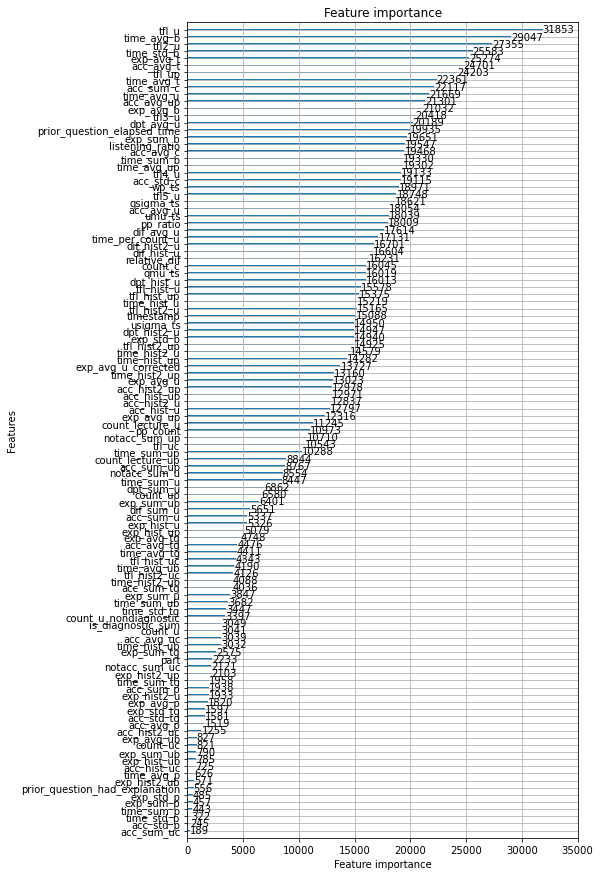

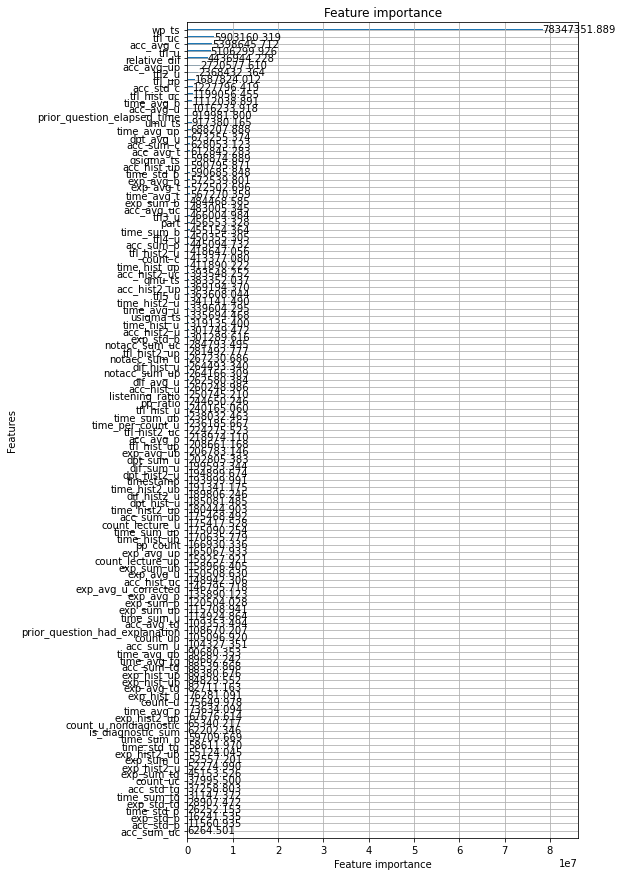

In [28]:
from pylab import rcParams
rcParams['figure.figsize'] = 7, 15
ax = lgb.plot_importance(lgb_model)
ax.figure.savefig('lgb_model_feature_importace.png')
ax = lgb.plot_importance(lgb_model, importance_type = "gain")
ax.figure.savefig('lgb_model_feature_importace_gain.png')

In [29]:
prior_b_dict = pickle_load_dill('../input/riid-preprocessed/prior_b_dict.pickle')
diagnostic_u_dict = pickle_load_dill('../input/riid-preprocessed/diagnostic_u_dict.pickle')    
question_trueskill_dict = pickle_load_dill('../input/riid-preprocessed/question_trueskill_dict.pickle')
user_trueskill_dict = pickle_load_dill('../input/riid-preprocessed/user_trueskill_dict.pickle')

To use sqlite DB, we have to copy it to working directory.

In [30]:
!cp -r '../input/riid-preprocessed/feat_new.db' ./ 
dbname = './feat_new.db'

# Submit

In [31]:
pbar = tqdm(total=2500000)
previous_test_df = None
counter = 0
conn = sqlite3.connect(dbname) 
for (test_df, sample_prediction_df) in iter_test:
    counter += 1
    if previous_test_df is not None:
        previous_test_df[TARGET] = eval(test_df["prior_group_answers_correct"].iloc[0])
        update_feats_sqlite(previous_test_df, conn)
        update_trueskill(previous_test_df, user_trueskill_dict, question_trueskill_dict, verbose=False)
        if not counter % 100:
            conn.commit()
    test_df.timestamp=(test_df.timestamp/1000).astype('int32')
    test_df = add_prior_b(test_df, questions_cb, questions_bpt, prior_b_dict,verbose=False)
    test_df['col_for_merge']=(test_df['content_id'].astype('int32')*10+test_df['content_type_id']).astype('int32')
    test_df = test_df.merge(content_df, how = 'left', on = 'col_for_merge')
    test_df.content_id=test_df.content_id.astype('int32')
    test_df['prior_question_elapsed_time'] = test_df['prior_question_elapsed_time'].fillna(25439.41)
    test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].fillna(False).astype('int8')
    previous_test_df = test_df.copy()
    test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop=True)
    test_df = add_feats_without_update_sqlite(test_df, conn)
    test_df = add_is_diagnostic(test_df, diagnostic_u_dict,verbose=False)
    test_df = add_trueskill_without_update(test_df, user_trueskill_dict, question_trueskill_dict, verbose=False)
    test_df = add_new_columns(test_df)
    test_df = fillna_df(test_df)
    lgb_result =  lgb_model.predict(test_df[FEATS])
    test_df[TARGET] = lgb_result
    set_predict(test_df[['row_id', TARGET]])
    pbar.update(len(test_df))